In [1]:
import tables
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import matplotlib.pyplot as plt
from ctapipe.image import tailcuts_clean
from scipy.interpolate import griddata
from astropy import units as u
import numpy as np

In [44]:
data_path = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
#data_path = '/Users/nicolamarinello/Downloads/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data = tables.open_file(data_path)

# acquire the data
data_ainfo = data.root.Array_Info
data_einfo = data.root.Event_Info
data_LST = data.root.LST

print(repr(data_ainfo))
print(repr(data_einfo))
print(repr(data_LST))

# array info data
ai_run_array_direction = [x['run_array_direction']
                          for x in data_ainfo.iterrows()]
ai_tel_id = [x['tel_id'] for x in data_ainfo.iterrows()]
ai_tel_type = [x['tel_type'] for x in data_ainfo.iterrows()]
ai_tel_x = [x['tel_x'] for x in data_ainfo.iterrows()]
ai_tel_y = [x['tel_y'] for x in data_ainfo.iterrows()]
ai_tel_z = [x['tel_z'] for x in data_ainfo.iterrows()]

# event info data
ei_alt = [x['alt'] for x in data_einfo.iterrows()]
ei_az = [x['az'] for x in data_einfo.iterrows()]
ei_core_x = [x['core_x'] for x in data_einfo.iterrows()]
ei_core_y = [x['core_y'] for x in data_einfo.iterrows()]
ei_event_number = [x['event_number'] for x in data_einfo.iterrows()]
ei_h_first_int = [x['h_first_int'] for x in data_einfo.iterrows()]
ei_mc_energy = [x['mc_energy'] for x in data_einfo.iterrows()]
ei_particle_id = [x['particle_id'] for x in data_einfo.iterrows()]
ei_run_number = [x['run_number'] for x in data_einfo.iterrows()]
ei_LST_indices = [x['LST_indices'] for x in data_einfo.iterrows()]

# LST data
LST_event_index = [x['event_index'] for x in data_LST.iterrows()]
LST_image_charge = [x['image_charge'] for x in data_LST.iterrows()]
LST_image_peak_times = [x['image_peak_times'] for x in data_LST.iterrows()]

/Array_Info (Table(289,)) 'Table of array data'
  description := {
  "run_array_direction": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "tel_id": UInt8Col(shape=(), dflt=0, pos=1),
  "tel_type": StringCol(itemsize=8, shape=(), dflt=b'', pos=2),
  "tel_x": Float32Col(shape=(), dflt=0.0, pos=3),
  "tel_y": Float32Col(shape=(), dflt=0.0, pos=4),
  "tel_z": Float32Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (2259,)
/Event_Info (Table(4853,)) 'Table of Events'
  description := {
  "alt": Float32Col(shape=(), dflt=0.0, pos=0),
  "az": Float32Col(shape=(), dflt=0.0, pos=1),
  "core_x": Float32Col(shape=(), dflt=0.0, pos=2),
  "core_y": Float32Col(shape=(), dflt=0.0, pos=3),
  "event_number": UInt32Col(shape=(), dflt=0, pos=4),
  "h_first_int": Float32Col(shape=(), dflt=0.0, pos=5),
  "mc_energy": Float32Col(shape=(), dflt=0.0, pos=6),
  "particle_id": UInt8Col(shape=(), dflt=0, pos=7),
  "run_number": UInt32Col(shape=(), dflt=0, pos=8),
  "LST_indices": Int32Col(sha

In [45]:
#e_idx = 58 , 674
e_idx = 2229
# select a spcific event
my_event = data_einfo[e_idx]
print('Event number: {}'.format(my_event['event_number']))
print('Energy: {} TeV'.format(my_event['mc_energy']))
print('Alt: {} rad'.format(my_event['alt']))
print('Az: {} rad'.format(my_event['az']))
my_indices = my_event['LST_indices']
print('LST_indices: ' + str(my_indices))

Event number: 375601
Energy: 0.9098318815231323 TeV
Alt: 1.2217304706573486 rad
Az: 6.283185005187988 rad
LST_indices: [2869 2870 2871 2872]


In [46]:
#we will take always the first lst index just for demostrations
# print event information
img_charge = LST_image_charge[my_indices[0]]
img_time = LST_image_peak_times[my_indices[0]]
print(img_charge)
print(img_time)

[-2.4409199  -0.7888425  -1.6547577  ... -1.2159475   2.3322046
 -0.56620854]
[16. 27.  0. ... 25. 26. 24.]


In [47]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(10, 16))

# plt.suptitle('EVENT')
disps = []

ax = plt.subplot(2, 1, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge, picture_thresh=10, boundary_thresh=5
)
clean = img_charge.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_charge
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_charge)

grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(2, 1, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)
plt.tight_layout()
#plt.savefig('real-interp.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

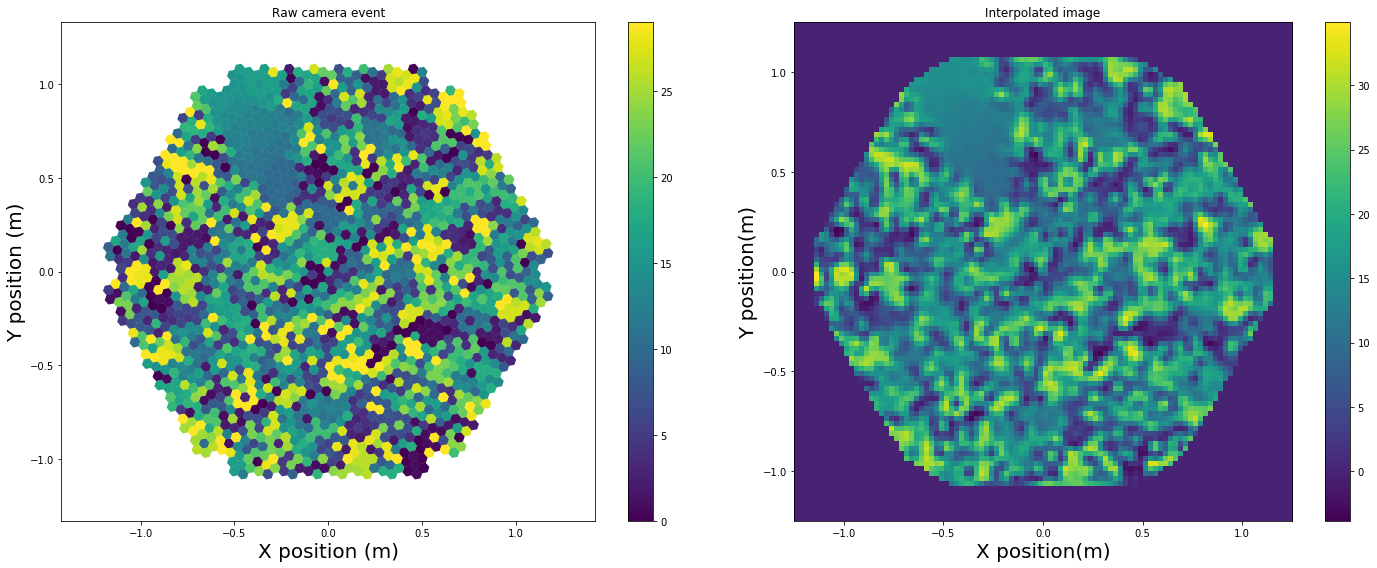

In [48]:
# Load the camera
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(20, 8))

#plt.suptitle('EVENT')
disps = []

ax = plt.subplot(1, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_time, picture_thresh=10, boundary_thresh=5
)
clean = img_time.copy()
clean[~cleanmask] = 0.0

# Show the camera image and overlay Hillas ellipse and clean
# pixels
disp.image = img_time
# disp.cmap = 'inferno'
# disp.highlight_pixels(cleanmask, color='crimson')
disps.append(disp)

# interpolation

points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_time)

#grid_x, grid_y = np.mgrid[-1.17:1.17:100j, -1.17:1.17:100j]
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')

grid_z = np.nan_to_num(grid_z)

ax = plt.subplot(1, 2, 2)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inferno = plt.get_cmap('inferno')
#inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', cmap=inferno)
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="equal")
plt.colorbar(inter, ax=ax)
plt.tight_layout()
plt.savefig('real-interp-time.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

In [49]:
%matplotlib inline 
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(26, 20))

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'axes.labelsize': 20})

ax = plt.subplot(2, 2, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()
disp.image = img_charge

ax = plt.subplot(2, 2, 3)
points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_charge)
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z = np.nan_to_num(grid_z)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)


ax = plt.subplot(2, 2, 2)
disp = CameraDisplay(geom, ax=ax, title="Raw camera event")
disp.add_colorbar()
disp.image = img_time


ax = plt.subplot(2, 2, 4)
points = np.array([np.array(geom.pix_x / u.m), np.array(geom.pix_y / u.m)]).T
values = np.array(img_time)
grid_x, grid_y = np.mgrid[-1.25:1.25:100j, -1.25:1.25:100j]
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z = np.nan_to_num(grid_z)
ax.set_title('Interpolated image')
ax.set_xlabel('X position(m)')
ax.set_ylabel('Y position(m)')
inter = ax.imshow(grid_z.T, extent=(-1.25, 1.25, -1.25, 1.25), origin='lower', aspect="auto")
plt.colorbar(inter, ax=ax)


plt.tight_layout()
plt.savefig('real-interp-4.eps', format='eps', bbox_inches='tight', pad_inches=0)

In [50]:
print(100*100 - np.count_nonzero(grid_z))

3750


In [51]:
print(grid_z[99][:])
print(grid_z.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(100, 100)


{'intensity': 1408.6658382415771,
 'kurtosis': 2.0663543519750247,
 'length': <Quantity 0.17381068 m>,
 'phi': <Angle 2.06827824 rad>,
 'psi': <Angle -1.09110863 rad>,
 'r': <Quantity 0.79771159 m>,
 'skewness': -0.28098394031337504,
 'width': <Quantity 0.04199072 m>,
 'x': <Quantity -0.38067929 m>,
 'y': <Quantity 0.70101859 m>}


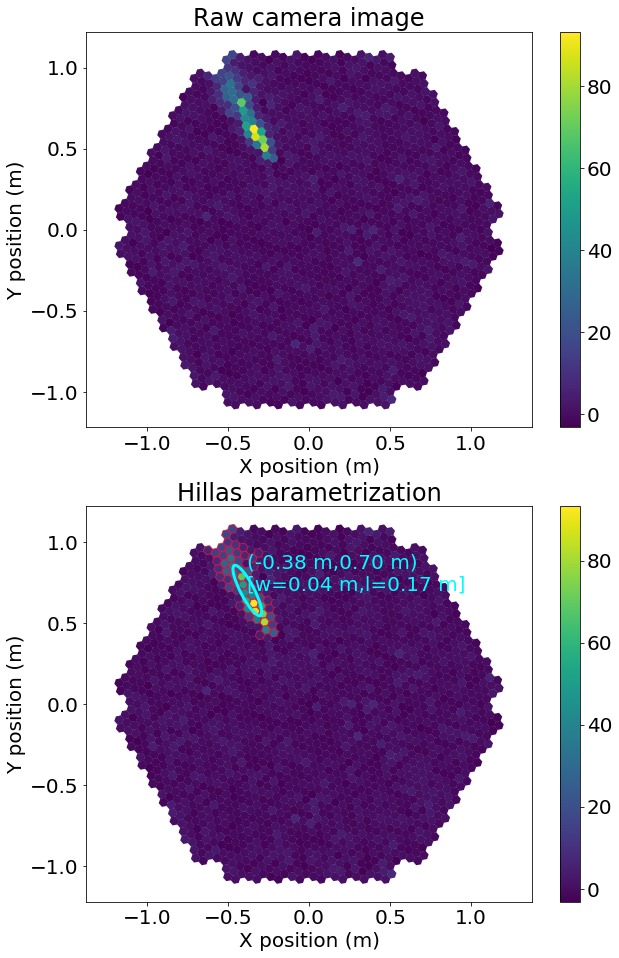

In [52]:
# hillas parameters

from ctapipe.image import toymodel, hillas_parameters, tailcuts_clean
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

# Load the camera
geom = CameraGeometry.from_name("LSTCam")
fig = plt.figure(figsize=(10, 16))

ax = plt.subplot(2, 1, 1)

disp = CameraDisplay(geom, ax=ax, title="Raw camera image")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
# cleanmask = tailcuts_clean(
#    geom, img_charge, picture_thresh=10, boundary_thresh=5
#)

# Calculate image parameters
#hillas = hillas_parameters(geom[cleanmask], img_charge[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
disp.image = img_charge
#disp.highlight_pixels(cleanmask, color='crimson')
#disp.overlay_moments(hillas, color='cyan', linewidth=3)

# Load the camera
geom = CameraGeometry.from_name("LSTCam")

ax = plt.subplot(2, 1, 2)

disp = CameraDisplay(geom, ax=ax, title="Hillas parametrization")
disp.add_colorbar()

# Create a fake camera image to display:
# model = toymodel.generate_2d_shower_model(
#    centroid=(0.2, 0.0), width=0.05, length=0.15, psi='35d'
# )

#image, sig, bg = toymodel.make_toymodel_shower_image(
#    geom, model.pdf, intensity=1500, nsb_level_pe=3
#)

# Apply image cleaning
cleanmask = tailcuts_clean(
    geom, img_charge, picture_thresh=10, boundary_thresh=5
)

# Calculate image parameters
hillas = hillas_parameters(geom[cleanmask], img_charge[cleanmask])

# Show the camera image and overlay Hillas ellipse and clean pixels
disp.image = img_charge
disp.highlight_pixels(cleanmask, color='crimson')
disp.overlay_moments(hillas, color='cyan', linewidth=3)

print(hillas)

# plt.show()

# plt.savefig('raw_hilas.eps', format='eps', bbox_inches='tight', pad_inches=0.9)

2356
117
474
Energy: 1.5281083583831787 TeV
Energy: 93.2811050415039 TeV
Energy: 106.3115463256836 TeV
[3031 3032 3033 3034]
[32 33 34 35]
[198   0   0 199]


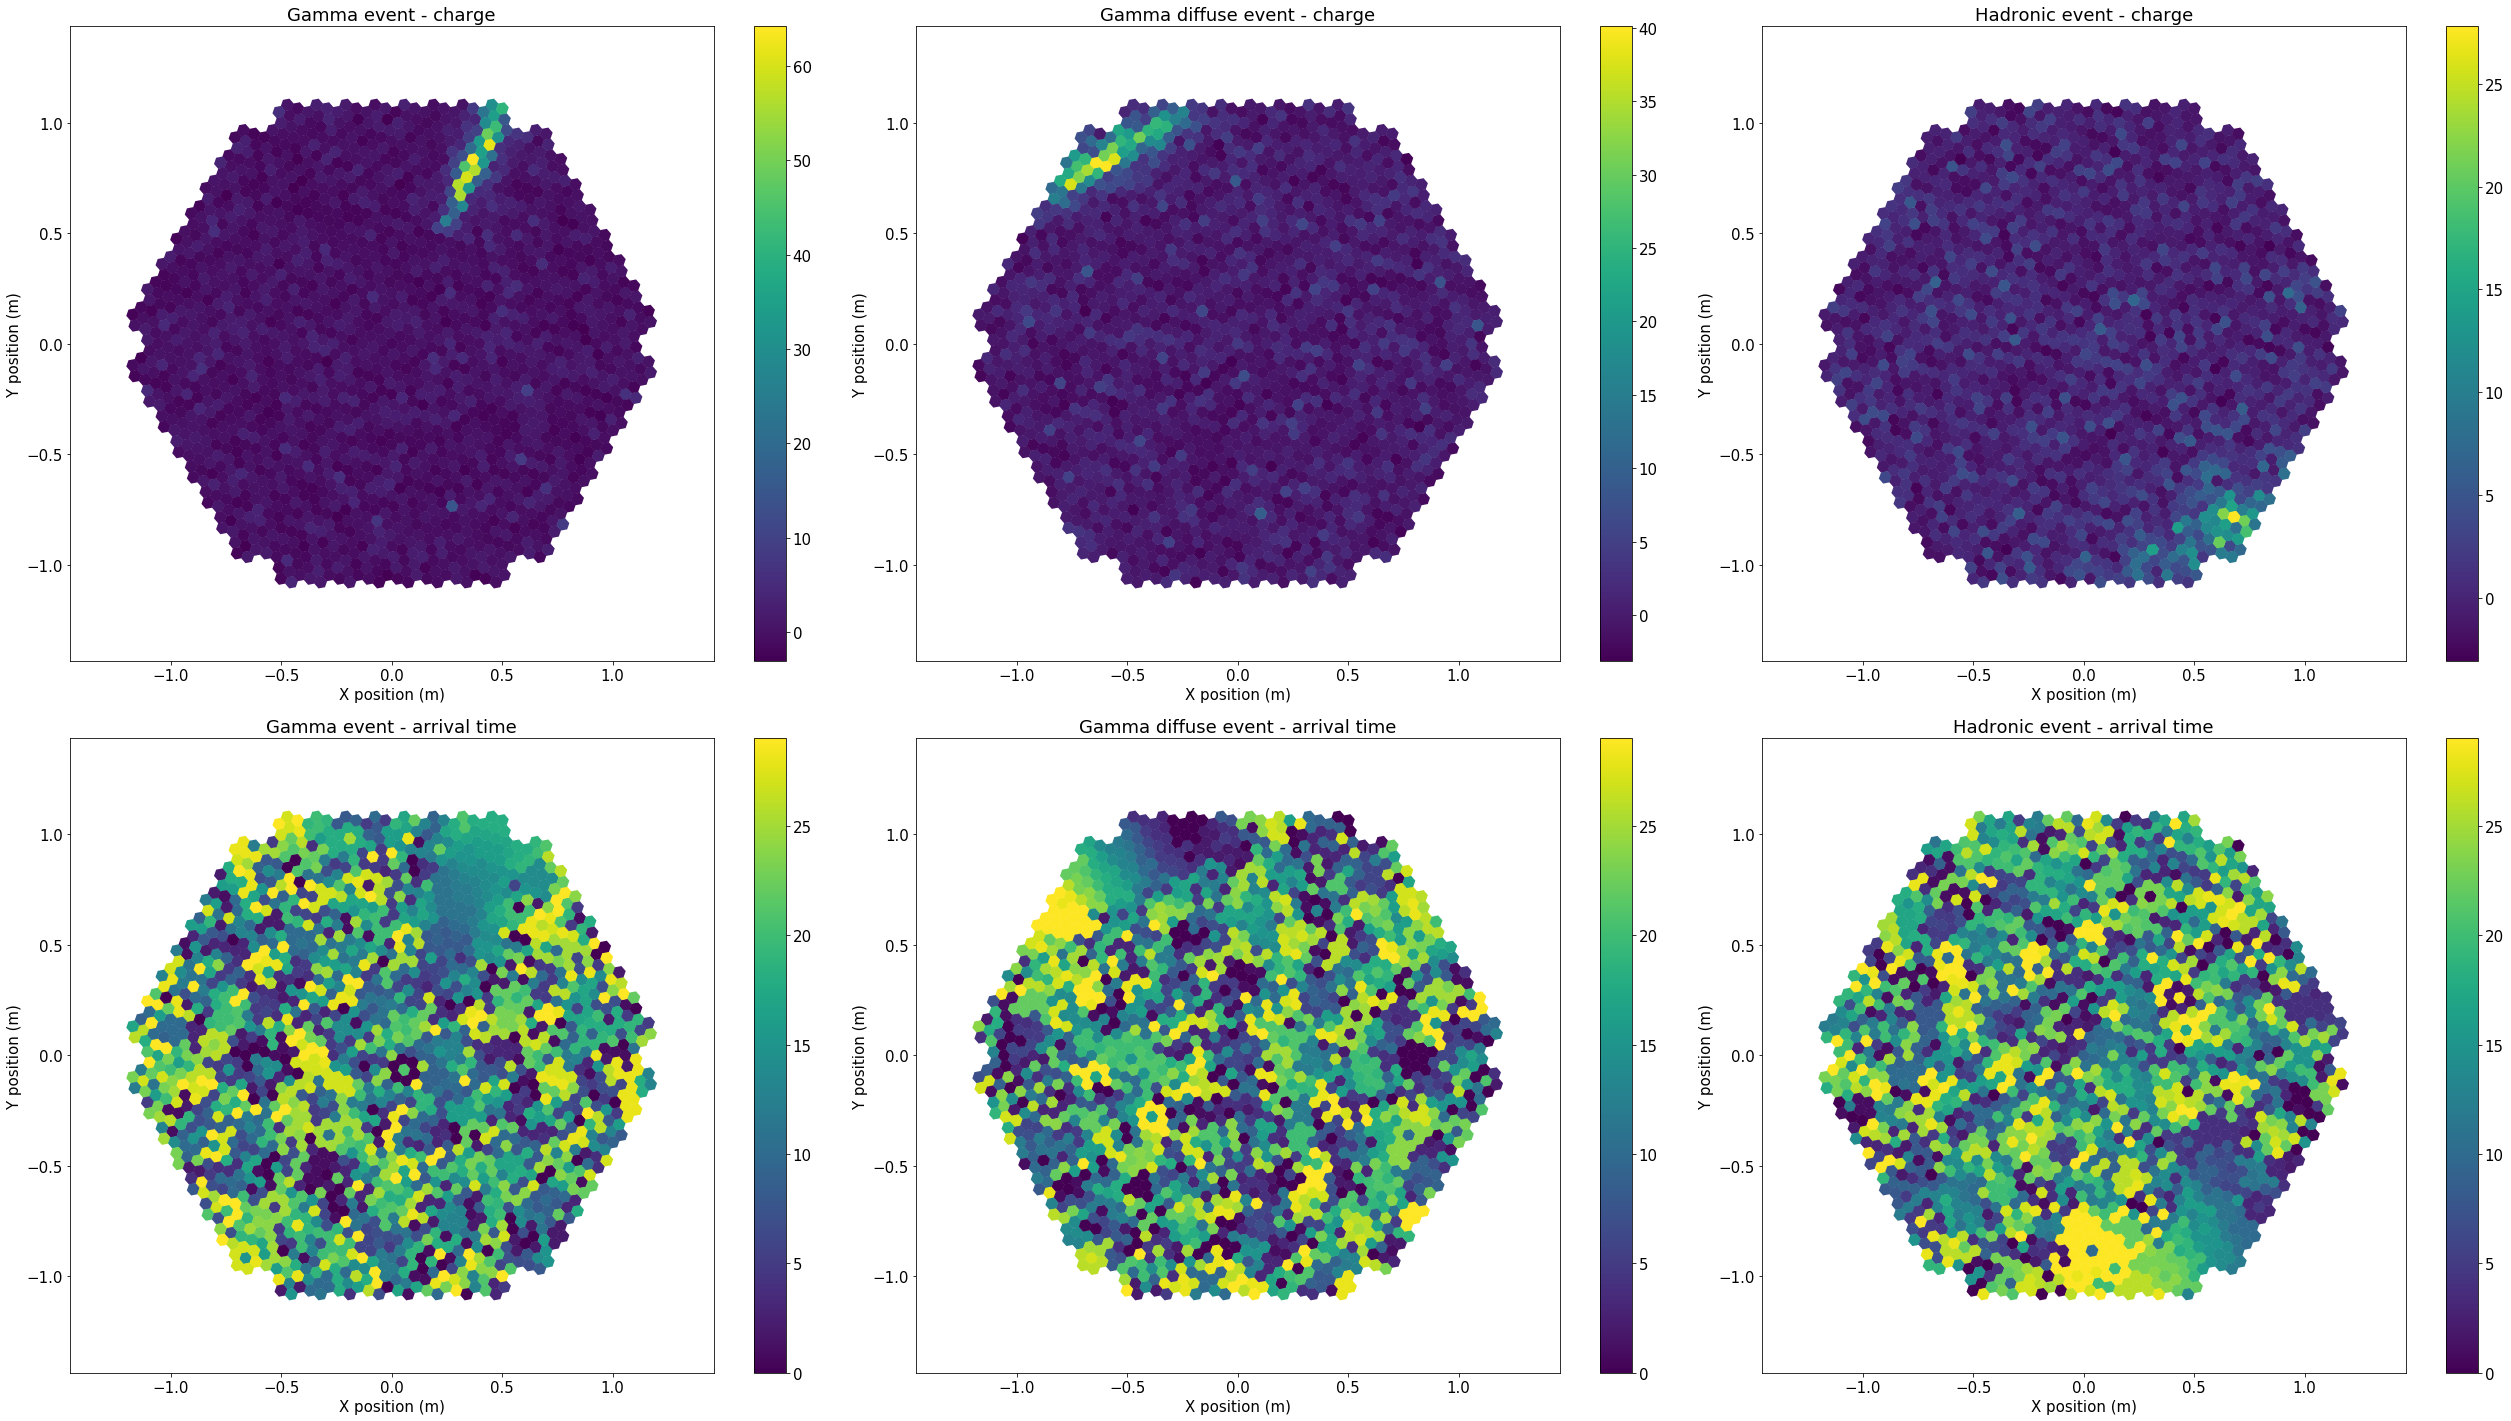

In [21]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
import numpy as np
import matplotlib

data_path_gamma = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data_path_gamdi = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1/gamma_20deg_0deg_srun1000-5606___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5'
data_path_proto = '/Volumes/home/Development/AIs/CTA/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1/proton_20deg_0deg_srun971-3870___cta-prod3_desert-2150m-Paranal-HB9.h5'

data_gamma = tables.open_file(data_path_gamma)
data_gamdi = tables.open_file(data_path_gamdi)
data_proto = tables.open_file(data_path_proto)

# acquire the data
data_LST_gamma = data_gamma.root.LST
data_LST_gamdi = data_gamdi.root.LST
data_LST_proto = data_proto.root.LST
data_einfo_gamma = data_gamma.root.Event_Info
data_einfo_gamdi = data_gamdi.root.Event_Info
data_einfo_proto = data_proto.root.Event_Info

# LST data
LST_event_index_gamma = [x['event_index'] for x in data_LST_gamma.iterrows()]
LST_image_charge_gamma = [x['image_charge'] for x in data_LST_gamma.iterrows()]
LST_image_peak_times_gamma = [x['image_peak_times'] for x in data_LST_gamma.iterrows()]
ei_mc_energy_gamma = [x['mc_energy'] for x in data_einfo_gamma.iterrows()]

LST_event_index_gamdi = [x['event_index'] for x in data_LST_gamdi.iterrows()]
LST_image_charge_gamdi = [x['image_charge'] for x in data_LST_gamdi.iterrows()]
LST_image_peak_times_gamdi = [x['image_peak_times'] for x in data_LST_gamdi.iterrows()]
ei_mc_energy_gamdi = [x['mc_energy'] for x in data_einfo_gamdi.iterrows()]

LST_event_index_proto = [x['event_index'] for x in data_LST_proto.iterrows()]
LST_image_charge_proto = [x['image_charge'] for x in data_LST_proto.iterrows()]
LST_image_peak_times_proto = [x['image_peak_times'] for x in data_LST_proto.iterrows()]
ei_mc_energy_proto = [x['mc_energy'] for x in data_einfo_proto.iterrows()]

#e_idx_gamma = 3135
#e_idx_gamdi = 153
#e_idx_proto = 753

e_idx_gamma = np.argsort(-np.array(ei_mc_energy_gamma), axis=0)[553]
e_idx_gamdi = np.argsort(-np.array(ei_mc_energy_gamdi), axis=0)[10]
e_idx_proto = np.argsort(-np.array(ei_mc_energy_proto), axis=0)[64]
print(e_idx_gamma)
print(e_idx_gamdi)
print(e_idx_proto)

my_event_gamma = data_einfo_gamma[e_idx_gamma]
my_event_gamdi = data_einfo_gamdi[e_idx_gamdi]
my_event_proto = data_einfo_proto[e_idx_proto]

print('Energy: {} TeV'.format(my_event_gamma['mc_energy']))
print('Energy: {} TeV'.format(my_event_gamdi['mc_energy']))
print('Energy: {} TeV'.format(my_event_proto['mc_energy']))

my_indices_gamma = my_event_gamma['LST_indices']
my_indices_gamdi = my_event_gamdi['LST_indices']
my_indices_proto = my_event_proto['LST_indices']
print(my_indices_gamma)
print(my_indices_gamdi)
print(my_indices_proto)

img_charge_gamma = LST_image_charge_gamma[my_indices_gamma[0]]
img_time_gamma = LST_image_peak_times_gamma[my_indices_gamma[0]]

img_charge_gamdi = LST_image_charge_gamdi[my_indices_gamdi[0]]
img_time_gamdi = LST_image_peak_times_gamdi[my_indices_gamdi[0]]

img_charge_proto = LST_image_charge_proto[my_indices_proto[0]]
img_time_proto = LST_image_peak_times_proto[my_indices_proto[0]]

# Load the camera
geom = CameraGeometry.from_name("LSTCam")
f = 2
fig = plt.figure(figsize=(36, 20))

ax = plt.subplot(2, 3, 1)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - charge")
disp.add_colorbar()
disp.image = img_charge_gamma

ax = plt.subplot(2, 3, 2)
disp = CameraDisplay(geom, ax=ax, title="Gamma diffuse event - charge")
disp.add_colorbar()
disp.image = img_charge_gamdi

ax = plt.subplot(2, 3, 3)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - charge")
disp.add_colorbar()
disp.image = img_charge_proto

ax = plt.subplot(2, 3, 4)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamma

ax = plt.subplot(2, 3, 5)
disp = CameraDisplay(geom, ax=ax, title="Gamma diffuse event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamdi

ax = plt.subplot(2, 3, 6)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - arrival time")
disp.add_colorbar()
disp.image = img_time_proto

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

# matplotlib.rc('font', **font)

plt.tight_layout()
plt.savefig('dataset_example.eps', format='eps', bbox_inches='tight', pad_inches=0)

In [41]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay
from ctapipe.image import toymodel
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tables

data_path_gamma = '/Users/nicolamarinello/simulations/gamma_20deg_0deg_srun800-4169___cta-prod3_desert-2150m-Paranal-HB9.h5'
data_path_proto = '/Users/nicolamarinello/simulations/proton_20deg_0deg_srun971-3870___cta-prod3_desert-2150m-Paranal-HB9.h5'

data_gamma = tables.open_file(data_path_gamma)
data_proto = tables.open_file(data_path_proto)

# acquire the data
data_LST_gamma = data_gamma.root.LST
data_LST_proto = data_proto.root.LST
data_einfo_gamma = data_gamma.root.Event_Info
data_einfo_proto = data_proto.root.Event_Info

# LST data
LST_event_index_gamma = [x['event_index'] for x in data_LST_gamma.iterrows()]
LST_image_charge_gamma = [x['image_charge'] for x in data_LST_gamma.iterrows()]
LST_image_peak_times_gamma = [x['image_peak_times'] for x in data_LST_gamma.iterrows()]
ei_mc_energy_gamma = [x['mc_energy'] for x in data_einfo_gamma.iterrows()]

LST_event_index_proto = [x['event_index'] for x in data_LST_proto.iterrows()]
LST_image_charge_proto = [x['image_charge'] for x in data_LST_proto.iterrows()]
LST_image_peak_times_proto = [x['image_peak_times'] for x in data_LST_proto.iterrows()]
ei_mc_energy_proto = [x['mc_energy'] for x in data_einfo_proto.iterrows()]

#e_idx_gamma = 3135 or 553
#e_idx_gamdi = 153
#e_idx_proto = 753

e_idx_gamma = np.argsort(-np.array(ei_mc_energy_gamma), axis=0)[553]
e_idx_proto = np.argsort(-np.array(ei_mc_energy_proto), axis=0)[64]
print(e_idx_gamma)
print(e_idx_proto)

my_event_gamma = data_einfo_gamma[e_idx_gamma]
my_event_proto = data_einfo_proto[e_idx_proto]

print('Energy: {} TeV'.format(my_event_gamma['mc_energy']))
print('Energy: {} TeV'.format(my_event_proto['mc_energy']))

my_indices_gamma = my_event_gamma['LST_indices']
my_indices_proto = my_event_proto['LST_indices']
print(my_indices_gamma)
print(my_indices_proto)

img_charge_gamma = LST_image_charge_gamma[my_indices_gamma[0]]
img_time_gamma = LST_image_peak_times_gamma[my_indices_gamma[0]]

img_charge_proto = LST_image_charge_proto[my_indices_proto[0]]
img_time_proto = LST_image_peak_times_proto[my_indices_proto[0]]

# Load the camera
geom = CameraGeometry.from_name("LSTCam")

'''
#overwrite with a toy model
# create a fake camera image to display:

model = toymodel.Gaussian(
    x=0.2 * u.m,
    y=0.0 * u.m,
    width=0.05 * u.m,
    length=0.15 * u.m,
    psi='35d',
)

img_charge_gamma, sig, bg = model.generate_image(geom, intensity=1500, nsb_level_pe=5)
'''

f = 2
fig = plt.figure(figsize=(26, 20))

matplotlib.rcParams.update({'font.size': 20})
matplotlib.rcParams.update({'axes.labelsize': 20})

ax = plt.subplot(2, 2, 1)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - charge")
disp.add_colorbar()
disp.image = img_charge_gamma

ax = plt.subplot(2, 2, 2)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - charge")
disp.add_colorbar()
disp.image = img_charge_proto

ax = plt.subplot(2, 2, 3)
disp = CameraDisplay(geom, ax=ax, title="Gamma event - arrival time")
disp.add_colorbar()
disp.image = img_time_gamma

ax = plt.subplot(2, 2, 4)
disp = CameraDisplay(geom, ax=ax, title="Hadronic event - arrival time")
disp.add_colorbar()
disp.image = img_time_proto

plt.tight_layout()
plt.savefig('dataset_example.eps', format='eps', bbox_inches='tight', pad_inches=0)

2356
474
Energy: 1.5281083583831787 TeV
Energy: 106.3115463256836 TeV
[3031 3032 3033 3034]
[198   0   0 199]


In [24]:
# execute on VM with ipython
from keras.utils.data_utils import OrderedEnqueuer
from keras.utils.generic_utils import Progbar

from generators import DataGeneratorR
from utils import get_all_files
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib

def retrieve_energy(generator):
    # retrieve energy
    print('Retrieving ground truth...')
    gt_feature = []
    steps_done = 0
    steps = len(generator)

    enqueuer = OrderedEnqueuer(generator, use_multiprocessing=True)
    enqueuer.start(workers=24, max_queue_size=10)
    output_generator = enqueuer.get()

    progbar = Progbar(target=steps)

    while steps_done < steps:
        generator_output = next(output_generator)
        _, y = generator_output
        gt_feature.append(y)
        # print('steps_done', steps_done)
        # print(y)
        steps_done += 1
        progbar.update(steps_done)
        
    return np.array(gt_feature)
        

data_path_gamma = ['/ssdraptor/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1_interp/']
data_path_gamdi = ['/ssdraptor/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1_interp/','/ssdraptor/simulations/Paranal_gamma-diffuse_North_20deg_3HB9_DL1_ML1_interp/validation']
data_path_proto = ['/ssdraptor/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp/','/ssdraptor/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp/validation/','/ssdraptor/simulations/Paranal_proton_North_20deg_3HB9_DL1_ML1_interp_test/']

h5files_gamma = get_all_files(data_path_gamma)
h5files_gamdi = get_all_files(data_path_gamdi)
h5files_proto = get_all_files(data_path_proto)

print('Building test generator...')
generator_gamma = DataGeneratorR(h5files_gamma, feature='energy', batch_size=64, arrival_time=False, shuffle=False)
generator_gamdi = DataGeneratorR(h5files_gamdi, feature='energy', batch_size=64, arrival_time=False, shuffle=False)
generator_proto = DataGeneratorR(h5files_proto, feature='energy', batch_size=64, arrival_time=False, shuffle=False)

ei_mc_energy_gamma = retrieve_energy(generator_gamma)
ei_mc_energy_gamdi = retrieve_energy(generator_gamdi)
ei_mc_energy_proto = retrieve_energy(generator_proto)

ei_mc_energy_gamma = np.array(ei_mc_energy_gamma).reshape(64*len(generator_gamma))
ei_mc_energy_gamdi = np.array(ei_mc_energy_gamdi).reshape(64*len(generator_gamdi))
ei_mc_energy_proto = np.array(ei_mc_energy_proto).reshape(64*len(generator_proto))

f = 1.5
fig = plt.figure(figsize=(10*f, 7*f))

matplotlib.rcParams.update({'font.size': 13})

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)

bins = 50

ax = plt.subplot(gs[0, :2], )
#ax = plt.subplot(1, 3, 1)
plt.hist(ei_mc_energy_gamma, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events')
plt.title('Gamma energy distribution')

#ax = plt.subplot(1, 3, 2)
ax = plt.subplot(gs[0, 2:])
plt.hist(ei_mc_energy_gamdi, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events')
plt.title('Gamma-diffuse energy distribution')

#ax = plt.subplot(1, 3, 3)
ax = plt.subplot(gs[1, 1:3])
plt.hist(ei_mc_energy_proto, bins)
plt.yscale('log', nonposy='clip')
plt.xlabel('$log_{10}E_{event}[TeV]$')
plt.ylabel('# of events')
plt.title('Protons energy distribution')

#plt.suptitle('Dataset energy distribution')

plt.tight_layout()
plt.savefig('dataset_distrib.eps', format='eps', bbox_inches='tight', pad_inches=0)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/simulations/Paranal_gamma_North_20deg_3HB9_DL1_ML1_interp/'

In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import pandas as pd

dnh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/DenseNet_2019-04-16_09-11/train-history'
dnr = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/DenseNet_2019-04-16_09-11/DenseNet_42_0.80866_0.80057.h5_test.csv'

rnfh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-18_06-31/train-history'
rnfr = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-18_06-31/ResNetF_49_0.78691_0.78701.h5_test.csv'

rnfnoath = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-17_15-34/train-history'
rnfnoatr = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetF_2019-04-17_15-34/ResNetF_34_0.77160_0.77273.h5_test.csv'

rnfseh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetFSE_2019-05-11_11-04/train-history'
rnfser = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/ResNetFSE_2019-05-11_11-04/ResNetFSE_43_0.81421_0.80588.h5_test.csv'

baselineh = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/BaseLine_2019-05-14_10-33/train-history'
baseliner = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/BaseLine_2019-05-14_10-33/BaseLine_38_0.81494_0.79406.h5_test.csv'

# plot epochs vs test accuracy & ROCs

#history
with open(dnh, 'rb') as f:
    densenet_history = pickle.load(f)
with open(rnfh, 'rb') as f:
    resnetf_history = pickle.load(f)
with open(rnfnoath, 'rb') as f:
    resnetfnoat_history = pickle.load(f)
with open(rnfseh, 'rb') as f:
    rnfse_history = pickle.load(f)
with open(baselineh, 'rb') as f:
    baseline_history = pickle.load(f)    

#compute ROCs
densenet_csv = pd.read_csv(dnr)
resnetf_csv = pd.read_csv(rnfr)
resnetfnoat_csv = pd.read_csv(rnfnoatr)
rnfse_csv = pd.read_csv(rnfser)
baseline_csv = pd.read_csv(baseliner)

rf_table = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/RF_results/RF_test-table.pkl'
with open(rf_table, 'rb') as f:
    rf_test_table = pickle.load(f)
    
fpr_densenet, tpr_densenet, _ = roc_curve(densenet_csv['GroundTruth'], densenet_csv['Predicted'])
fpr_resnetf, tpr_resnetf, _ = roc_curve(resnetf_csv['GroundTruth'], resnetf_csv['Predicted'])
fpr_resnetfnoat, tpr_resnetfnoat, _ = roc_curve(resnetfnoat_csv['GroundTruth'], resnetfnoat_csv['Predicted'])
fpr_rnfse, tpr_rnfse, _ = roc_curve(rnfse_csv['GroundTruth'], rnfse_csv['Predicted'])
fpr_baseline, tpr_baseline, _ = roc_curve(baseline_csv['GroundTruth'], baseline_csv['Predicted'])
fpr_rf, tpr_rf, _ = roc_curve(rf_test_table['label'], rf_test_table['gammanes'])


epochs = 50

# training & test accuracy
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]
ax.plot(densenet_history['val_accuracy'], label='DenseNet', color=cmap(0))
ax.plot(resnetf_history['val_accuracy'], label='ResNetF', color=cmap(1))
ax.plot(resnetfnoat_history['val_accuracy'], label='ResNetF - no AT', color=cmap(2))
ax.plot(rnfse_history['val_accuracy'][0:49], label='ResNetFSE', color=cmap(3))
ax.plot(baseline_history['val_accuracy'], label='Baseline', color=cmap(4))
ax.plot(densenet_history['accuracy'], ':', color=cmap(0))
ax.plot(resnetf_history['accuracy'], ':', color=cmap(1))
ax.plot(resnetfnoat_history['accuracy'], ':', color=cmap(2))
ax.plot(rnfse_history['accuracy'][0:49], ':', color=cmap(3))
ax.plot(baseline_history['accuracy'], ':', color=cmap(4))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(True)

ax = axs[1]
ax.plot(fpr_densenet, tpr_densenet, label='DenseNet', color=cmap(0))
ax.plot(fpr_resnetf, tpr_resnetf, label='ResNetF', color=cmap(1))
ax.plot(fpr_resnetfnoat, tpr_resnetfnoat, label='ResNetF - no AT', color=cmap(2))
ax.plot(fpr_rnfse, tpr_rnfse, label='ResNetFSE', color=cmap(3))
ax.plot(fpr_baseline, tpr_baseline, label='Baseline', color=cmap(4))
ax.plot(fpr_rf, tpr_rf, ':', color='black', label='Random Forest')
ax.set_xlabel('False Positive Rate (1-specitivity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(True)

plt.tight_layout()
plt.show()
fig.savefig('paper_class.eps', format='eps', transparent=False)

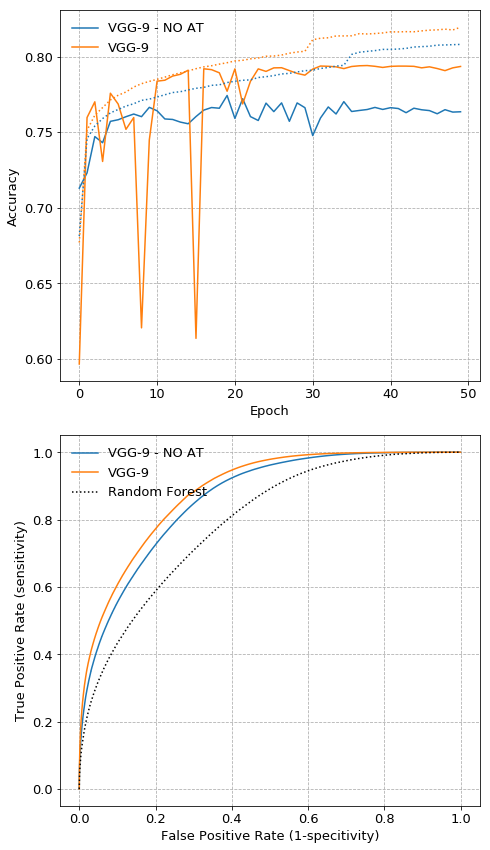

In [5]:

###############################################################################

###################### ARRIVAL TIME GAIN SEPARATION ###########################                

###############################################################################

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import pandas as pd

baselineNOATh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/BaseLine_2019-05-17_09-29/train-history'
baselineNOATr = '//Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/BaseLine_2019-05-17_09-29/BaseLine_20_0.78280_0.77425.h5_test.csv'

baselineh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/BaseLine_2019-05-14_10-33/train-history'
baseliner = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/SUCCESSFUL/BaseLine_2019-05-14_10-33/BaseLine_38_0.81494_0.79406.h5_test.csv'

# plot epochs vs test accuracy & ROCs

#history
#with open(baselineNOATh, 'rb') as f:
#    baselineNOAT_history = pickle.load(f)
#with open(baselineh, 'rb') as f:
#    baseline_history = pickle.load(f) 
    
baselineNOAT_history = pickle.load(open(baselineNOATh, 'rb'))
baseline_history = pickle.load(open(baselineh, 'rb'))

#compute ROCs
baselineNOAT_csv = pd.read_csv(baselineNOATr)
baseline_csv = pd.read_csv(baseliner)

rf_table = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/RF_results/RF_test-table.pkl'
with open(rf_table, 'rb') as f:
    rf_test_table = pickle.load(f)
    
fpr_baselineNOAT, tpr_baselineNOAT, _ = roc_curve(baselineNOAT_csv['GroundTruth'], baselineNOAT_csv['Predicted'])
fpr_baseline, tpr_baseline, _ = roc_curve(baseline_csv['GroundTruth'], baseline_csv['Predicted'])
fpr_rf, tpr_rf, _ = roc_curve(rf_test_table['label'], rf_test_table['gammanes'])


epochs = 50

# training & test accuracy
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 12))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]
ax.plot(baselineNOAT_history['val_accuracy'], label='VGG-9 - NO AT', color=cmap(0))
ax.plot(baseline_history['val_accuracy'], label='VGG-9', color=cmap(1))
ax.plot(baselineNOAT_history['accuracy'], ':', color=cmap(0))
ax.plot(baseline_history['accuracy'], ':', color=cmap(1))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, linestyle='--')

ax = axs[1]
ax.plot(fpr_baselineNOAT, tpr_baselineNOAT, label='VGG-9 - NO AT', color=cmap(0))
ax.plot(fpr_baseline, tpr_baseline, label='VGG-9', color=cmap(1))
ax.plot(fpr_rf, tpr_rf, ':', color='black', label='Random Forest')
ax.set_xlabel('False Positive Rate (1-specitivity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, linestyle='--')

plt.tight_layout()
plt.show()
fig.savefig('at_gain_baseline.eps', format='eps', transparent=False)

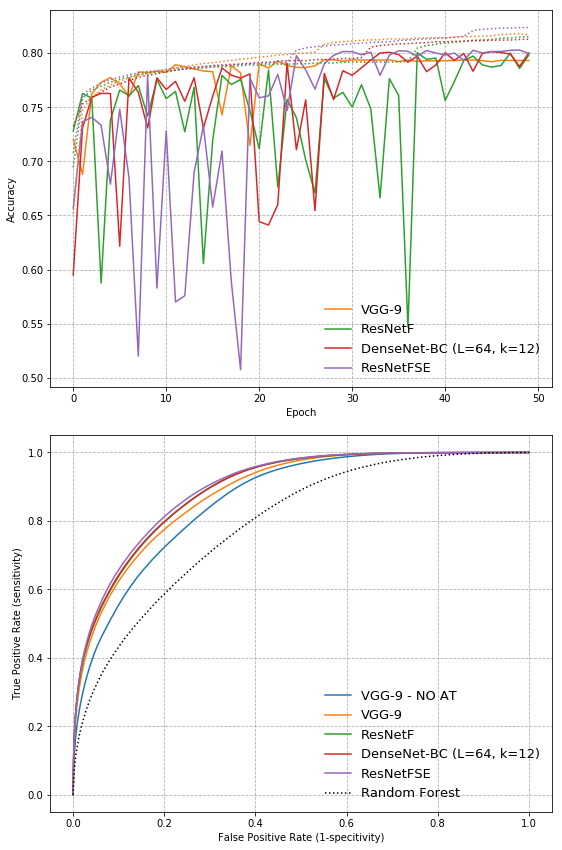

In [2]:
###############################################################################

############################## SEPARATION #####################################                

###############################################################################

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import pandas as pd

baselineNOATh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_10-40/train-history'
baselineNOATr = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_10-40/BaseLine_20_0.78306_0.77448.h5_test.csv'

baselineh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_21-54/train-history'
baseliner = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/BaseLine_2019-05-22_21-54/BaseLine_29_0.80983_0.79393.h5_test.csv'

rnfh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetF_2019-05-23_18-54/train-history'
rnfr = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetF_2019-05-23_18-54/ResNetF_38_0.80475_0.80049.h5_test.csv'

dnh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/DenseNet_2019-05-26_15-20/train-history'
dnr = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/DenseNet_2019-05-26_15-20/DenseNet_46_0.81200_0.80139.h5_test.csv'

rnfseh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetFSE_2019-05-29_23-23/train-history'
rnfser = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/separation/thesis/ResNetFSE_2019-05-29_23-23/ResNetFSE_49_0.82375_0.80292.h5_test.csv'

# plot epochs vs test accuracy & ROCs

#history
baselineNOAT_history = pickle.load(open(baselineNOATh, 'rb'))
baseline_history = pickle.load(open(baselineh, 'rb'))
rnf_history = pickle.load(open(rnfh, 'rb'))
dn_history = pickle.load(open(dnh, 'rb'))
rnfse_history = pickle.load(open(rnfseh, 'rb'))

#compute ROCs
baselineNOAT_csv = pd.read_csv(baselineNOATr)
baseline_csv = pd.read_csv(baseliner)
rnf_csv = pd.read_csv(rnfr)
dn_csv = pd.read_csv(dnr)
rnfse_csv = pd.read_csv(rnfser)

rf_table = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/RF_test-table.pkl'
with open(rf_table, 'rb') as f:
    rf_test_table = pickle.load(f)
    
fpr_baselineNOAT, tpr_baselineNOAT, _ = roc_curve(baselineNOAT_csv['GroundTruth'], baselineNOAT_csv['Predicted'])
fpr_baseline, tpr_baseline, _ = roc_curve(baseline_csv['GroundTruth'], baseline_csv['Predicted'])
fpr_rnf, tpr_rnf, _ = roc_curve(rnf_csv['GroundTruth'], rnf_csv['Predicted'])
fpr_dn, tpr_dn, _ = roc_curve(dn_csv['GroundTruth'], dn_csv['Predicted'])
fpr_rnfse, tpr_rnfse, _ = roc_curve(rnfse_csv['GroundTruth'], rnfse_csv['Predicted'])
fpr_rf, tpr_rf, _ = roc_curve(rf_test_table['label'], rf_test_table['gammanes'])

epochs = 50

# training & test accuracy
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]

#ax.plot(baselineNOAT_history['val_accuracy'], label='VGG-9 - NO AT', color=cmap(0))
ax.plot(baseline_history['val_accuracy'], label='VGG-9', color=cmap(1))
ax.plot(rnf_history['val_accuracy'], label='ResNetF', color=cmap(2))
ax.plot(dn_history['val_accuracy'], label='DenseNet-BC (L=64, k=12)', color=cmap(3))
ax.plot(rnfse_history['val_accuracy'], label='ResNetFSE', color=cmap(4))

#ax.plot(baselineNOAT_history['accuracy'], ':', color=cmap(0))
ax.plot(baseline_history['accuracy'], ':', color=cmap(1))
ax.plot(rnf_history['accuracy'], ':', color=cmap(2))
ax.plot(dn_history['accuracy'], ':', color=cmap(3))
ax.plot(rnfse_history['accuracy'], ':', color=cmap(4))

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.plot(fpr_baselineNOAT, tpr_baselineNOAT, label='VGG-9 - NO AT', color=cmap(0))
ax.plot(fpr_baseline, tpr_baseline, label='VGG-9', color=cmap(1))
ax.plot(fpr_rnf, tpr_rnf, label='ResNetF', color=cmap(2))
ax.plot(fpr_dn, tpr_dn, label='DenseNet-BC (L=64, k=12)', color=cmap(3))
ax.plot(fpr_rnfse, tpr_rnfse, label='ResNetFSE', color=cmap(4))
ax.plot(fpr_rf, tpr_rf, ':', color='black', label='Random Forest')
ax.set_xlabel('False Positive Rate (1-specitivity)')
ax.set_ylabel('True Positive Rate (sensitivity)')
ax.legend(loc='lower right', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
plt.show()
fig.savefig('class_res.eps', format='eps', transparent=False)

644890
645734


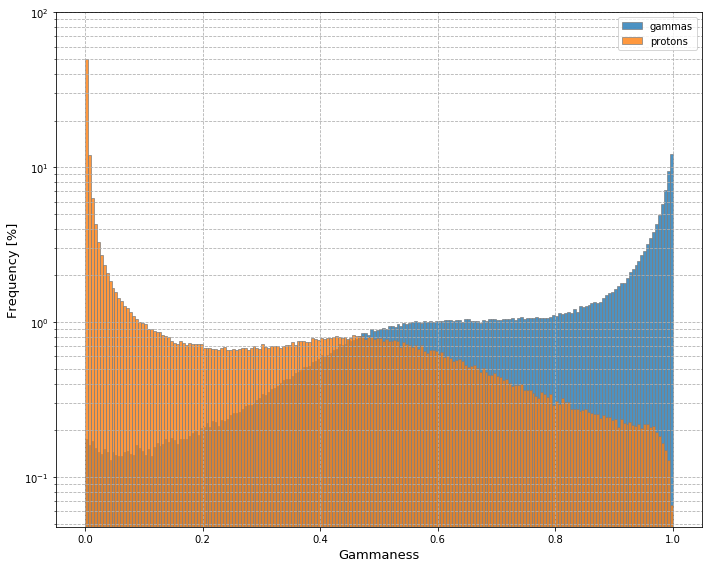

In [26]:
###############################################################################

####################### SEPARATION PROB DISTR BEST ############################                

###############################################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

rnfse_csv_g = rnfse_csv[rnfse_csv['GroundTruth'] == 1]
rnfse_csv_p = rnfse_csv[rnfse_csv['GroundTruth'] == 0]

g_count = rnfse_csv_g.shape[0]
p_count = rnfse_csv_p.shape[0]

print(g_count)
print(p_count)

fig = plt.figure(figsize=(10, 8))

plt.hist(rnfse_csv_g['Predicted'], bins=200, density = True, label='gammas', alpha = 0.8, edgecolor='gray', linewidth=0.9)
plt.hist(rnfse_csv_p['Predicted'], bins=200, density = True, label='protons', alpha = 0.8, edgecolor='gray', linewidth=0.9)
plt.yscale('log')
plt.ylim(top=100)
plt.xlabel('Gammaness', fontsize=13)
plt.ylabel('Frequency [%]', fontsize=13)
plt.legend(loc='upper right')
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

fig.tight_layout()
plt.show()
fig.savefig('separation_best_probdistr.pdf', format='pdf', transparent=False)

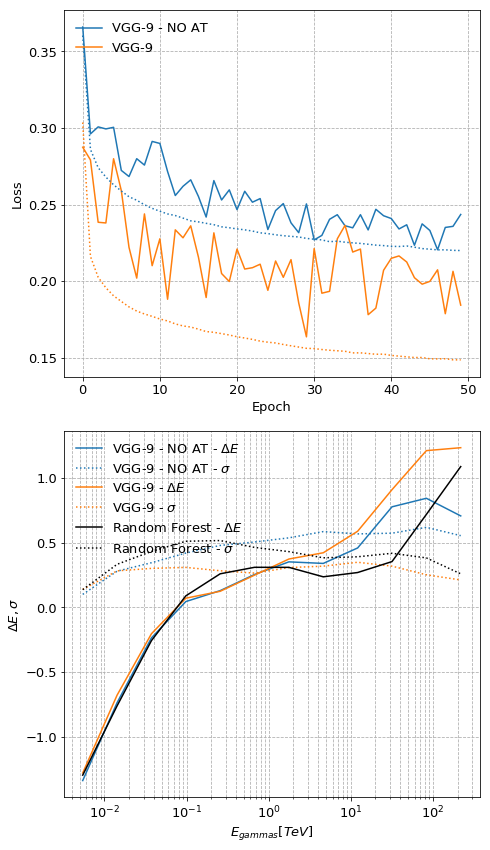

In [6]:
###############################################################################

###################### ARRIVAL TIME GAIN ENERGY RECO ##########################                

###############################################################################
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pickle

baselineeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/train-history'
baselineer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/BaseLine_30_0.15616_0.16365.h5_test.pkl'
baselineems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/mus_sigmas.npz'

baselineNOATeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/train-history'
baselineNOATer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/BaseLine_47_0.22042_0.22049.h5_test.pkl'
baselineNOATems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/mus_sigmas.npz'

#history
baseline_history = pickle.load(open(baselineeh, 'rb'))
baselineNOAT_history = pickle.load(open(baselineNOATeh, 'rb'))

# mus & sigma
baseline_ms = np.load(baselineems)
baselineNOAT_ms = np.load(baselineNOATems)

rfms = '/Users/nicolamarinello/ctasoft/cta-lstchain/cnn/RF_results/mus_sigmas.npz'
rf_ms = np.load(rfms)
    
epochs = 50

# training & test loss
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 12))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs[0]
ax.plot(baselineNOAT_history['val_losses'], label='VGG-9 - NO AT', color=cmap(0))
ax.plot(baseline_history['val_losses'], label='VGG-9', color=cmap(1))
ax.plot(baselineNOAT_history['losses'], ':', color=cmap(0))
ax.plot(baseline_history['losses'], ':', color=cmap(1))
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, linestyle='--')

ax = axs[1]
ax.semilogx(baselineNOAT_ms['bin_centers'], baselineNOAT_ms['mus'], label='VGG-9 - NO AT - $\Delta E$', color=cmap(0))
ax.semilogx(baselineNOAT_ms['bin_centers'], baselineNOAT_ms['sigmas'], ':', label='VGG-9 - NO AT - $\sigma$', color=cmap(0))
ax.semilogx(baseline_ms['bin_centers'], baseline_ms['mus'], label='VGG-9 - $\Delta E$', color=cmap(1))
ax.semilogx(baseline_ms['bin_centers'], baseline_ms['sigmas'], ':', label='VGG-9 - $\sigma$', color=cmap(1))
ax.semilogx(rf_ms['bin_centers'], rf_ms['mus'], color='black', label='Random Forest - $\Delta E$')
ax.semilogx(rf_ms['bin_centers'], rf_ms['sigmas'], ':', color='black', label='Random Forest - $\sigma$')
ax.set_xlabel('$E_{gammas}[TeV]$')
ax.set_ylabel(r'$\Delta E, \sigma$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_at_gain.eps', format='eps', transparent=False)

In [10]:
###############################################################################

######################################## ENERGY RECO ##########################                

###############################################################################
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib
import pickle

baselineNOATeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/train-history'
baselineNOATer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/BaseLine_47_0.22042_0.22049.h5_test.pkl'
baselineNOATems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-18_12-07/mus_sigmas.npz'

baselineeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/train-history'
baselineer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/BaseLine_30_0.15616_0.16365.h5_test.pkl'
baselineems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_energy_2019-05-16_10-12/mus_sigmas.npz'

resnetheh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_energy_2019-05-23_21-32/train-history'
resnether = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_energy_2019-05-23_21-32/ResNetH_27_0.11675_0.13286.h5_test.pkl'
resnethems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_energy_2019-05-23_21-32/mus_sigmas.npz'

resnethseeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_energy_2019-05-24_18-31/train-history'
resnethseer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_energy_2019-05-24_18-31/ResNetHSE_50_0.12730_0.13117.h5_test.pkl'
resnethseems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_energy_2019-05-24_18-31/mus_sigmas.npz'

densenet169eh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet169_energy_2019-05-25_21-38/train-history'
densenet169er = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet169_energy_2019-05-25_21-38/DenseNet169_43_0.13453_0.16394.h5_test.pkl'
densenet169ems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet169_energy_2019-05-25_21-38/mus_sigmas.npz'

denseneteh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/paper/DenseNet_energy_2019-04-19_16-01/train-history'
denseneter = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/paper/DenseNet_energy_2019-04-19_16-01/DenseNet_50_0.13568_0.13484.h5_test.pkl'
densenetems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/paper/DenseNet_energy_2019-04-19_16-01/mus_sigmas.npz'

resnetfseeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_energy_2019-05-20_11-23/train-history'
resnetfseer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_energy_2019-05-20_11-23/ResNetFSE_44_0.12432_0.12943.h5_test.pkl'
resnetfseems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_energy_2019-05-20_11-23/mus_sigmas.npz'

#resnethseMAPEeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria\ delle\ Telecomunicazioni/2\ Anno/thesis/results/regression/thesis/MAPE/ResNetHSE_energy_2019-05-27_14-01/train-history'
#resnethseMAPEer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetHSE_energy_2019-05-27_14-01/ResNetHSE_10_124.73765_102.66618.h5_test.pkl'
#resnethseMAPEems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/ResNetHSE_energy_2019-05-27_14-01/mus_sigmas.npz'

baselineMAPEeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/BaseLine_energy_2019-06-02_12-30/train-history'
baselineMAPEer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/BaseLine_energy_2019-06-02_12-30/BaseLine_81_58.00385_41.09523.h5_test.pkl'
baselineMAPEems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/BaseLine_energy_2019-06-02_12-30/mus_sigmas.npz'

densenetMAPEeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/DenseNet_energy_2019-06-09_07-47/train-history'
densenetMAPEer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/DenseNet_energy_2019-06-09_07-47/DenseNet_50_41.98650_41.43905.h5_test.pkl'
densenetMAPEems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MAPE/DenseNet_energy_2019-06-09_07-47/mus_sigmas.npz'

baselineMSEeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-12_10-56/train-history'
baselineMSEer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-12_10-56/BaseLine_28_0.05555_0.10574.h5_test.pkl'
baselineMSEems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-12_10-56/mus_sigmas.npz'

baselineNOATMSEeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-13_19-03/train-history'
baselineNOATMSEer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-13_19-03/BaseLine_28_0.11227_0.10560.h5_test.pkl'
baselineNOATMSEems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/BaseLine_energy_2019-06-13_19-03/mus_sigmas.npz'

resnethMSEeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetH_energy_2019-06-14_00-07/train-history'
resnethMSEer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetH_energy_2019-06-14_00-07/ResNetH_36_0.03970_0.05129.h5_test.pkl'
resnethMSEems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetH_energy_2019-06-14_00-07/mus_sigmas.npz'

densenetMSEeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/DenseNet_energy_2019-06-13_07-57/train-history'
densenetMSEer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/DenseNet_energy_2019-06-13_07-57/DenseNet_46_0.02955_0.03402.h5_test.pkl'
densenetMSEems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/DenseNet_energy_2019-06-13_07-57/mus_sigmas.npz'

resnetfseFIXEDMSEeh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetFSEFixed_energy_2019-06-14_09-33/train-history'
resnetfseFIXEDMSEer = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetFSEFixed_energy_2019-06-14_09-33/ResNetFSEFixed_50_0.03703_0.05513.h5_test.pkl'
resnetfseFIXEDMSEems = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE_ENERGY/ResNetFSEFixed_energy_2019-06-14_09-33/mus_sigmas.npz'

rftest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/RF_test-table.pkl'

In [11]:
def get_mus_sigmas(pkl, npoints, rf=False):
    
    df = pd.read_pickle(pkl)
    
    energy = 'GroundTruth'
    energy_reco = 'Predicted'
    if rf:
        df = df[df['label'] == 1]
        energy = 'mc_energy'
        energy_reco = 'mc_energy_reco'

    edges = np.linspace(min(df[energy]), 2, npoints + 1)
    mus = np.array([])
    sigmas = np.array([])

    for i in range(npoints):
        edge1 = edges[i]
        edge2 = edges[i+1]
        dfbe = df[(df[energy] >= edge1) & (df[energy] < edge2)]
        # histogram
        difE = ((dfbe[energy] - dfbe[energy_reco]) * np.log(10))
        # difE = difE[abs(difE) < 1.5]
        mu, sigma = norm.fit(difE)
        mus = np.append(mus, mu)
        sigmas = np.append(sigmas, sigma)
        
    edges = np.power(10, edges)
    bin_centers = (edges[:-1] + edges[1:]) / 2
        
    return bin_centers, mus, sigmas

In [12]:
def get_mape(gt, p):
    return np.mean(np.abs((gt - p) / gt))

df_rf = pd.read_pickle(rftest)
df_baselineNOAT = pd.read_pickle(baselineNOATer)
df_baseline = pd.read_pickle(baselineer)
df_resneth = pd.read_pickle(resnether)
df_resnethse = pd.read_pickle(resnethseer)
df_densenet169 = pd.read_pickle(densenet169er)
df_densenet = pd.read_pickle(denseneter)
df_resnetfse = pd.read_pickle(resnetfseer)
df_baselineMAPE = pd.read_pickle(baselineMAPEer)
df_densenetMAPE = pd.read_pickle(densenetMAPEer)
df_baselineMSE = pd.read_pickle(baselineMSEer)
df_baselineNOATMSE = pd.read_pickle(baselineNOATMSEer)
df_resnethMSE = pd.read_pickle(resnethMSEer)
df_densenetMSE = pd.read_pickle(densenetMSEer)
df_resnetfseFIXEDMSE = pd.read_pickle(resnetfseFIXEDMSEer)

print('MAPE RF', get_mape(df_rf['mc_energy'], df_rf['mc_energy_reco']))
print('MAPE baselineNOAT', get_mape(df_baselineNOAT['GroundTruth'], df_baselineNOAT['Predicted']))
print('MAPE baseline', get_mape(df_baseline['GroundTruth'], df_baseline['Predicted']))
print('MAPE resneth', get_mape(df_resneth['GroundTruth'], df_resneth['Predicted']))
print('MAPE resnethse', get_mape(df_resnethse['GroundTruth'], df_resnethse['Predicted']))
print('MAPE densenet169', get_mape(df_densenet169['GroundTruth'], df_densenet169['Predicted']))
print('MAPE densenet', get_mape(df_densenet['GroundTruth'], df_densenet['Predicted']))
print('MAPE resnetfse', get_mape(df_resnetfse['GroundTruth'], df_resnetfse['Predicted']))
print('MAPE baselineMAPE', get_mape(df_baselineMAPE['GroundTruth'], df_baselineMAPE['Predicted']))
print('MAPE densenetMAPE', get_mape(df_densenetMAPE['GroundTruth'], df_densenetMAPE['Predicted']))

print('MAPE baselineMSE', get_mape(df_baselineMSE['GroundTruth'], df_baselineMSE['Predicted']))
print('MAPE baselineNOATMSE', get_mape(df_baselineNOATMSE['GroundTruth'], df_baselineNOATMSE['Predicted']))
print('MAPE resnethMSE', get_mape(df_resnethMSE['GroundTruth'], df_resnethMSE['Predicted']))
print('MAPE densenetMSE', get_mape(df_densenetMSE['GroundTruth'], df_densenetMSE['Predicted']))
print('MAPE resnetfseFIXEDMSE', get_mape(df_resnetfseFIXEDMSE['GroundTruth'], df_resnetfseFIXEDMSE['Predicted']))

MAPE RF 9.273192352297945
MAPE baselineNOAT 1.3011632863502758
MAPE baseline 0.7539896643029571
MAPE resneth 0.4836645010888031
MAPE resnethse 0.428711301798327
MAPE densenet169 0.5653561297280056
MAPE densenet 0.5745260150256942
MAPE resnetfse 0.47670763296637875
MAPE baselineMAPE 0.39885735942087097
MAPE densenetMAPE 0.3559443368885525
MAPE baselineMSE 1.547779040754866
MAPE baselineNOATMSE 1.1092022980261838
MAPE resnethMSE 0.8258711987777475
MAPE densenetMSE 0.47950506063148196
MAPE resnetfseFIXEDMSE 0.4907044913259399


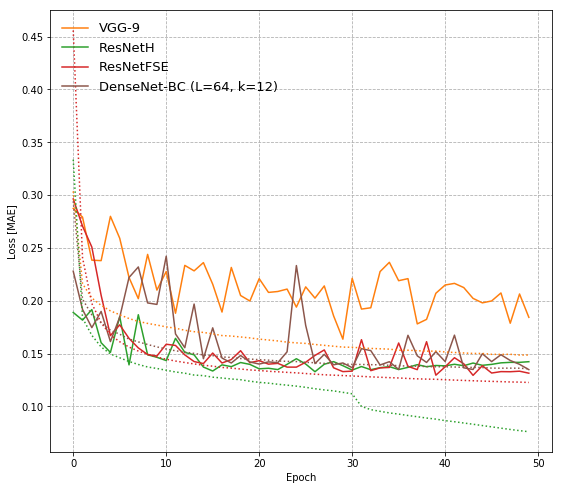

In [13]:
#################### LOSS ONLY ####################################

#history
baselineNOAT_history = pickle.load(open(baselineNOATeh, 'rb'))
baseline_history = pickle.load(open(baselineeh, 'rb'))
resneth_history = pickle.load(open(resnetheh, 'rb'))
resnethse_history = pickle.load(open(resnethseeh, 'rb'))
densenet169_history = pickle.load(open(densenet169eh, 'rb'))
densenet_history = pickle.load(open(denseneteh, 'rb'))
resnetfse_history = pickle.load(open(resnetfseeh, 'rb'))

'''
# mus & sigma
baselineNOAT_ms = np.load(baselineNOATems)
baseline_ms = np.load(baselineems)
resneth_ms = np.load(resnethems)
resnethse_ms = np.load(resnethseems)
densenet169_ms = np.load(densenet169ems)
densenet_ms = np.load(densenetems)
'''

# mus & sigma
npoints = 14
baselineNOAT_bc, baselineNOAT_m, baselineNOAT_s = get_mus_sigmas(baselineNOATer, npoints)
baseline_bc, baseline_m, baseline_s = get_mus_sigmas(baselineer, npoints)
resneth_bc, resneth_m, resneth_s = get_mus_sigmas(resnether, npoints)
resnethse_bc, resnethse_m, resnethse_s = get_mus_sigmas(resnethseer, npoints)
densenet169_bc, densenet169_m, densenet169_s = get_mus_sigmas(densenet169er, npoints)
densenet_bc, densenet_m, densenet_s = get_mus_sigmas(denseneter, npoints)
resnetfse_bc, resnetfse_m, resnetfse_s = get_mus_sigmas(resnetfseer, npoints)

baselineMAPE_bc, baselineMAPE_m, baselineMAPE_s = get_mus_sigmas(baselineMAPEer, npoints)
densenetMAPE_bc, densenetMAPE_m, densenetMAPE_s = get_mus_sigmas(densenetMAPEer, npoints)
baselineMSE_bc, baselineMSE_m, baselineMSE_s = get_mus_sigmas(baselineMSEer, npoints)
baselineNOATMSE_bc, baselineNOATMSE_m, baselineNOATMSE_s = get_mus_sigmas(baselineNOATMSEer, npoints)
resnethMSE_bc, resnethMSE_m, resnethMSE_s = get_mus_sigmas(resnethMSEer, npoints)
densenetMSE_bc, densenetMSE_m, densenetMSE_s = get_mus_sigmas(densenetMSEer, npoints)
resnetfseFIXEDMSE_bc, resnetfseFIXEDMSE_m, resnetfseFIXEDMSE_s = get_mus_sigmas(resnetfseFIXEDMSEer, npoints)

#rfms = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'
#rf_ms = np.load(rfms)


rf_bc, rf_m, rf_s = get_mus_sigmas(rftest, npoints, rf=True)
    
epochs = 50

# training & test loss
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 7))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

ax = axs
#ax.plot(baselineNOAT_history['val_losses'], label='VGG-9 - NO AT', color=cmap(0))
ax.plot(baseline_history['val_losses'], label='VGG-9', color=cmap(1))
ax.plot(resneth_history['val_losses'], label='ResNetH', color=cmap(2))
ax.plot(resnetfse_history['val_losses'], label='ResNetFSE', color=cmap(3))
#ax.plot(resnethse_history['val_losses'], label='ResNetHSE', color=cmap(3))
#ax.plot(densenet169_history['val_losses'], label='DenseNet169', color=cmap(4))
ax.plot(densenet_history['val_losses'], label='DenseNet-BC (L=64, k=12)', color=cmap(5))


#ax.plot(baselineNOAT_history['losses'], ':', color=cmap(0))
ax.plot(baseline_history['losses'], ':', color=cmap(1))
ax.plot(resneth_history['losses'], ':', color=cmap(2))
ax.plot(resnetfse_history['losses'], ':', color=cmap(3))
#ax.plot(resnethse_history['losses'], ':', color=cmap(3))
#ax.plot(densenet169_history['losses'], ':', color=cmap(4))
ax.plot(densenet_history['losses'], ':', color=cmap(5))


ax.set_xlabel('Epoch')
ax.set_ylabel('Loss [MAE]')
#ax.set_yscale('log')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_history.eps', format='eps', transparent=False)

In [17]:
"""
def get_mus_sigmas_const(df, npoints, rf=False):
    
    # df = pd.read_pickle(pkl)
    
    energy = 'GroundTruth'
    energy_reco = 'Predicted'
    if rf:
        df = df[df['label'] == 1]
        energy = 'mc_energy'
        energy_reco = 'mc_energy_reco'

    edges = np.linspace(min(df[energy]), 2, npoints + 1)
    mus = np.array([])
    sigmas = np.array([])

    for i in range(npoints):
        edge1 = edges[i]
        edge2 = edges[i+1]
        dfbe = df[(df[energy] >= edge1) & (df[energy] < edge2)]
        # histogram
        difE = ((dfbe[energy] - dfbe[energy_reco]) * np.log(10))
        # difE = difE[abs(difE) < 1.5]
        mu, sigma = norm.fit(difE)
        mus = np.append(mus, mu)
        sigmas = np.append(sigmas, sigma)
        
    edges = np.power(10, edges)
    bin_centers = (edges[:-1] + edges[1:]) / 2
        
    return bin_centers, mus, sigmas


df_CONST = df_resnetfseFIXEDMSE
df_CONST['Predicted'] = 0
CONST_bc, CONST_m, CONST_s = get_mus_sigmas_const(df_CONST, npoints)
"""

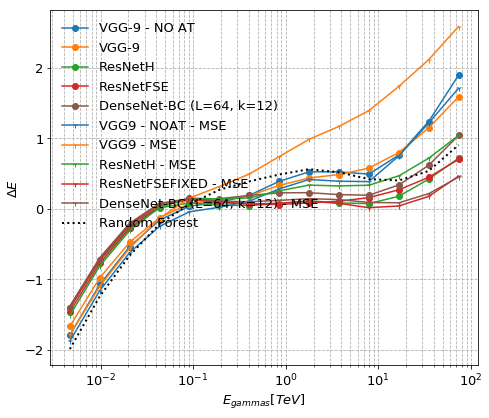

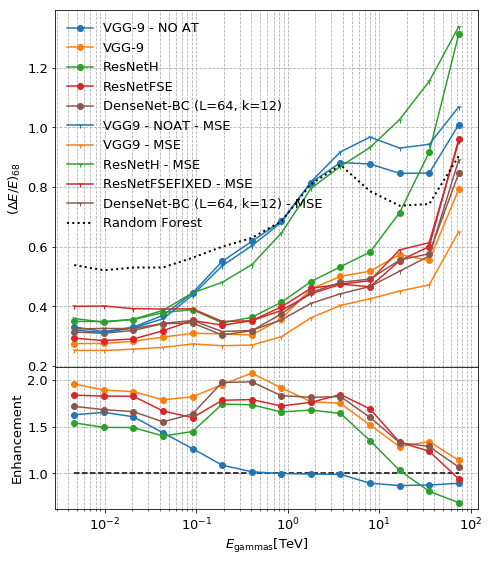

In [22]:
#################### BIAS AND RESOLUTION ####################################

rfms = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'
rf_ms = np.load(rfms)
    
epochs = 50

# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

plt.semilogx(baselineNOAT_bc, baselineNOAT_m, label='VGG-9 - NO AT', color=cmap(0), marker='o')
plt.semilogx(baseline_bc, baseline_m, label='VGG-9', color=cmap(1), marker='o')
plt.semilogx(resneth_bc, resneth_m, label='ResNetH', color=cmap(2), marker='o')
plt.semilogx(resnetfse_bc, resnetfse_m, label='ResNetFSE', color=cmap(3), marker='o')
#plt.semilogx(resnethse_bc, resnethse_m, label='ResNetHSE', color=cmap(3), marker='o')
#plt.semilogx(densenet169_bc, densenet169_m, label='DenseNet169', color=cmap(4), marker='o')
plt.semilogx(densenet_bc, densenet_m, label='DenseNet-BC (L=64, k=12)', color=cmap(5), marker='o')


#plt.semilogx(baselineMAPE_bc, baselineMAPE_m, label='VGG9 - MAPE', color=cmap(6), marker='o')
plt.semilogx(baselineNOATMSE_bc, baselineNOATMSE_m, label='VGG9 - NOAT - MSE', color=cmap(0), marker='1')
plt.semilogx(baselineMSE_bc, baselineMSE_m, label='VGG9 - MSE', color=cmap(1), marker='1')
plt.semilogx(resnethMSE_bc, resnethMSE_m, label='ResNetH - MSE', color=cmap(2), marker='1')
plt.semilogx(resnetfseFIXEDMSE_bc, resnetfseFIXEDMSE_m, label='ResNetFSEFIXED - MSE', color=cmap(3), marker='1')
plt.semilogx(densenetMSE_bc, densenetMSE_m, label='DenseNet-BC (L=64, k=12) - MSE', color=cmap(5), marker='1')
#plt.semilogx(CONST_bc, CONST_m, label='CONST', color=cmap(7), marker='D')


plt.semilogx(rf_bc, rf_m, color='black', label='Random Forest', linestyle=':', linewidth=2)
plt.xlabel('$E_{gammas}[TeV]$')
plt.ylabel(r'$\Delta E$')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_bias.eps', format='eps', transparent=False)
########################################################################################################
# reso & improvement
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 8), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1]})

ax = axs[0]
ax.semilogx(baselineNOAT_bc, baselineNOAT_s, label='VGG-9 - NO AT', color=cmap(0), marker='o')
ax.semilogx(baseline_bc, baseline_s, label='VGG-9', color=cmap(1), marker='o')
ax.semilogx(resneth_bc, resneth_s, label='ResNetH', color=cmap(2), marker='o')
ax.semilogx(resnetfse_bc, resnetfse_s, label='ResNetFSE', color=cmap(3), marker='o')
#ax.semilogx(resnethse_bc, resnethse_s, label='ResNetHSE', color=cmap(3), marker='o')
#ax.semilogx(densenet169_bc, densenet169_s, label='DenseNet-BC (L=64, k=12)', color=cmap(4), marker='o')
ax.semilogx(densenet_bc, densenet_s, label='DenseNet-BC (L=64, k=12)', color=cmap(5), marker='o')


#ax.semilogx(baselineMAPE_bc, baselineMAPE_s, label='VGG9 - MAPE', color=cmap(6), marker='o')
ax.semilogx(baselineNOATMSE_bc, baselineNOATMSE_s, label='VGG9 - NOAT - MSE', color=cmap(0), marker='1')
ax.semilogx(baselineMSE_bc, baselineMSE_s, label='VGG9 - MSE', color=cmap(1), marker='1')
ax.semilogx(resnethMSE_bc, resnethMSE_s, label='ResNetH - MSE', color=cmap(2), marker='1')
ax.semilogx(resnetfseFIXEDMSE_bc, resnetfseFIXEDMSE_s, label='ResNetFSEFIXED - MSE', color=cmap(3), marker='1')
ax.semilogx(densenetMSE_bc, densenetMSE_s, label='DenseNet-BC (L=64, k=12) - MSE', color=cmap(5), marker='1')
#ax.semilogx(CONST_bc, CONST_s, label='CONST', color=cmap(7), marker='D')

ax.semilogx(rf_bc, rf_s, color='black', label='Random Forest', linestyle=':', linewidth=2)
ax.set_xlabel('$E_{\mathrm{gammas}}$[TeV]')
ax.set_ylabel(r'$(\Delta E/E)_{68}$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.semilogx(baselineNOAT_bc, rf_s/baselineNOAT_s, label='RF/VGG-9 - NO AT', color=cmap(0), marker='o')
ax.semilogx(baseline_bc, rf_s/baseline_s, label='RF/VGG-9', color=cmap(1), marker='o')
ax.semilogx(resneth_bc, rf_s/resneth_s, label='RF/ResNetH', color=cmap(2), marker='o')
ax.semilogx(resnetfse_bc, rf_s/resnetfse_s, label='ResNetFSE', color=cmap(3), marker='o')
#ax.semilogx(resnethse_bc, rf_s/resnethse_s, label='RF/ResNetHSE', color=cmap(3), marker='o')
#ax.semilogx(densenet169_bc, rf_s/densenet169_s, label='DenseNet-BC (L=64, k=12)', color=cmap(4), marker='o')
ax.semilogx(densenet_bc, rf_s/densenet_s, label='DenseNet-BC (L=64, k=12)', color=cmap(5), marker='o')


#ax.semilogx(baselineMAPE_bc, rf_s/baselineMAPE_s, label='RF/VGG9 - MAPE', color=cmap(6), marker='o')

ax.hlines(1,baselineNOAT_bc.min(),baselineNOAT_bc.max(), color='black', linestyles='dashed')

ax.set_xlabel('$E_{\mathrm{gammas}}$[TeV]')
ax.set_ylabel('Enhancement')
# ax.legend(loc='lower left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_reso.eps', format='eps', transparent=False)

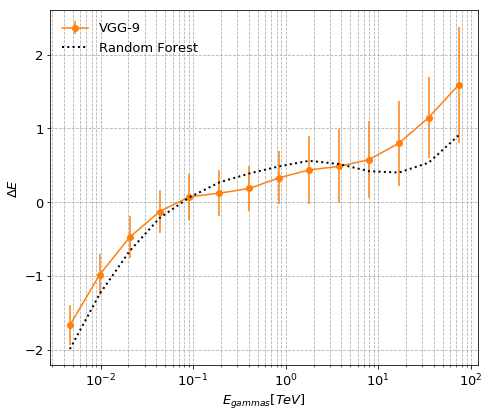

In [24]:

# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

#plt.errorbar(baselineNOAT_bc, baselineNOAT_m, yerr=baselineNOAT_s, label='VGG-9 - NO AT', color=cmap(0), marker='o')
plt.errorbar(baseline_bc, baseline_m, yerr=baseline_s, label='VGG-9', color=cmap(1), marker='o')
#plt.errorbar(resneth_bc, resneth_m, yerr=resneth_s, label='ResNetH', color=cmap(2), marker='o')
#plt.errorbar(resnetfse_bc, resnetfse_m, yerr=resnetfse_s, label='ResNetFSE', color=cmap(3), marker='o')
#plt.semilogx(resnethse_bc, resnethse_m, label='ResNetHSE', color=cmap(3), marker='o')
#plt.semilogx(densenet169_bc, densenet169_m, label='DenseNet169', color=cmap(4), marker='o')
#plt.errorbar(densenet_bc, densenet_m, yerr=densenet_s, label='DenseNet-BC (L=64, k=12)', color=cmap(5), marker='o')


#plt.semilogx(baselineMAPE_bc, baselineMAPE_m, label='VGG9 - MAPE', color=cmap(6), marker='o')
#plt.errorbar(baselineNOATMSE_bc, baselineNOATMSE_m, label='VGG9 - NOAT - MSE', color=cmap(0), marker='1')
#plt.errorbar(baselineMSE_bc, baselineMSE_m, label='VGG9 - MSE', color=cmap(1), marker='1')
#plt.errorbar(resnethMSE_bc, resnethMSE_m, label='ResNetH - MSE', color=cmap(2), marker='1')
#plt.errorbar(resnetfseFIXEDMSE_bc, resnetfseFIXEDMSE_m, label='ResNetFSEFIXED - MSE', color=cmap(3), marker='1')
#plt.errorbar(densenetMSE_bc, densenetMSE_m, label='DenseNet-BC (L=64, k=12) - MSE', color=cmap(5), marker='1')
#plt.semilogx(CONST_bc, CONST_m, label='CONST', color=cmap(7), marker='D')

plt.errorbar(rf_bc, rf_m, color='black', label='Random Forest', linestyle=':', linewidth=2)

plt.xscale('log', nonposx='clip')

plt.xlabel('$E_{gammas}[TeV]$')
plt.ylabel(r'$\Delta E$')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_errorbars.eps', format='eps', transparent=False)

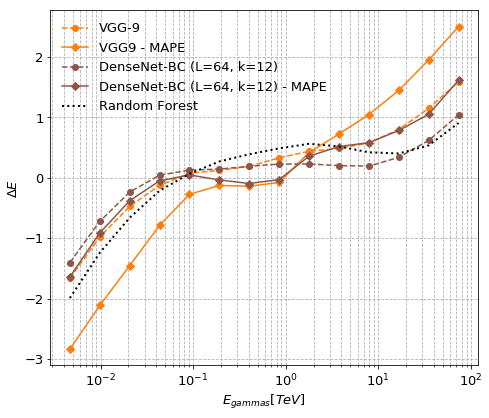

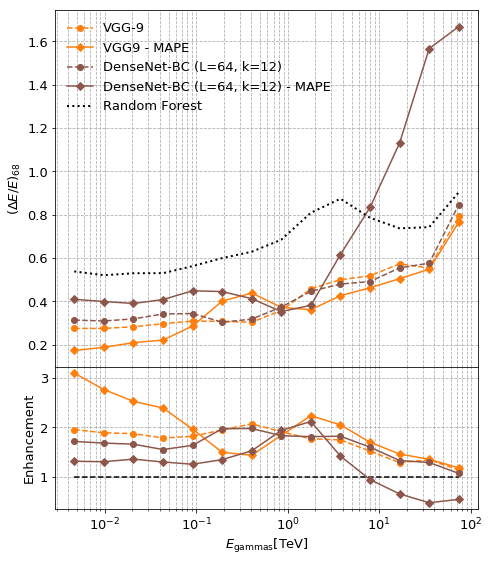

In [21]:
#################### BIAS AND RESOLUTION ####################################

rfms = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/mus_sigmas.npz'
rf_ms = np.load(rfms)
    
epochs = 50

# bias
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

plt.semilogx(baseline_bc, baseline_m, label='VGG-9', color=cmap(1), linestyle='--', marker='o')
plt.semilogx(baselineMAPE_bc, baselineMAPE_m, label='VGG9 - MAPE', color=cmap(1), marker='D')
plt.semilogx(densenet_bc, densenet_m, label='DenseNet-BC (L=64, k=12)', color=cmap(5), linestyle='--', marker='o')
plt.semilogx(densenetMAPE_bc, densenetMAPE_m, label='DenseNet-BC (L=64, k=12) - MAPE', color=cmap(5), marker='D')

plt.semilogx(rf_bc, rf_m, color='black', label='Random Forest', linestyle=':', linewidth=2)
plt.xlabel('$E_{gammas}[TeV]$')
plt.ylabel(r'$\Delta E$')

plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_bias_MAPE.eps', format='eps', transparent=False)
########################################################################################################
# reso & improvement
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 8), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1]})

ax = axs[0]
ax.semilogx(baseline_bc, baseline_s, label='VGG-9', color=cmap(1), linestyle='--', marker='o')
ax.semilogx(baselineMAPE_bc, baselineMAPE_s, label='VGG9 - MAPE', color=cmap(1), marker='D')
ax.semilogx(densenet_bc, densenet_s, label='DenseNet-BC (L=64, k=12)', color=cmap(5), linestyle='--', marker='o')
ax.semilogx(densenetMAPE_bc, densenetMAPE_s, label='DenseNet-BC (L=64, k=12) - MAPE', color=cmap(5), marker='D')

ax.semilogx(rf_bc, rf_s, color='black', label='Random Forest', linestyle=':', linewidth=2)
ax.set_xlabel('$E_{\mathrm{gammas}}$[TeV]')
ax.set_ylabel(r'$(\Delta E/E)_{68}$')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.semilogx(baseline_bc, rf_s/baseline_s, label='RF/VGG-9', color=cmap(1), linestyle='--', marker='o')
ax.semilogx(baselineMAPE_bc, rf_s/baselineMAPE_s, label='RF/VGG9 - MAPE', color=cmap(1), marker='D')
ax.semilogx(densenet_bc, rf_s/densenet_s, label='RF/DenseNet-BC (L=64, k=12)', color=cmap(5), marker='o')
ax.semilogx(densenetMAPE_bc, rf_s/densenetMAPE_s, label='RF/DenseNet-BC (L=64, k=12) - MAPE', color=cmap(5), marker='D')

ax.hlines(1,baselineNOAT_bc.min(),baselineNOAT_bc.max(), color='black', linestyles='dashed')

ax.set_xlabel('$E_{\mathrm{gammas}}$[TeV]')
ax.set_ylabel('Enhancement')
# ax.legend(loc='lower left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('energy_reso_MAPE.eps', format='eps', transparent=False)

MU:  -1.5486929856321823 SIGMA:  0.2864236346401974 N EVENTS: 1759
MU:  -0.8046421496030276 SIGMA:  0.2877383453022994 N EVENTS: 41106
MU:  -0.30946504594246327 SIGMA:  0.29591994673848354 N EVENTS: 160069
MU:  0.004535683562187847 SIGMA:  0.3070932580613971 N EVENTS: 175419
MU:  0.11912640122919364 SIGMA:  0.3105241239277748 N EVENTS: 127334
MU:  0.17629465760649277 SIGMA:  0.3048455528884891 N EVENTS: 76743
MU:  0.33845772236569277 SIGMA:  0.3676920434139403 N EVENTS: 37006
MU:  0.45294519317277293 SIGMA:  0.47498837596353055 N EVENTS: 15534
MU:  0.5052907585008422 SIGMA:  0.49669291285658596 N EVENTS: 5998
MU:  0.6922362649802981 SIGMA:  0.5606926552577136 N EVENTS: 2440
MU:  1.0173646945135917 SIGMA:  0.561093099342328 N EVENTS: 892
MU:  1.5428410058410649 SIGMA:  0.7409958205964664 N EVENTS: 386


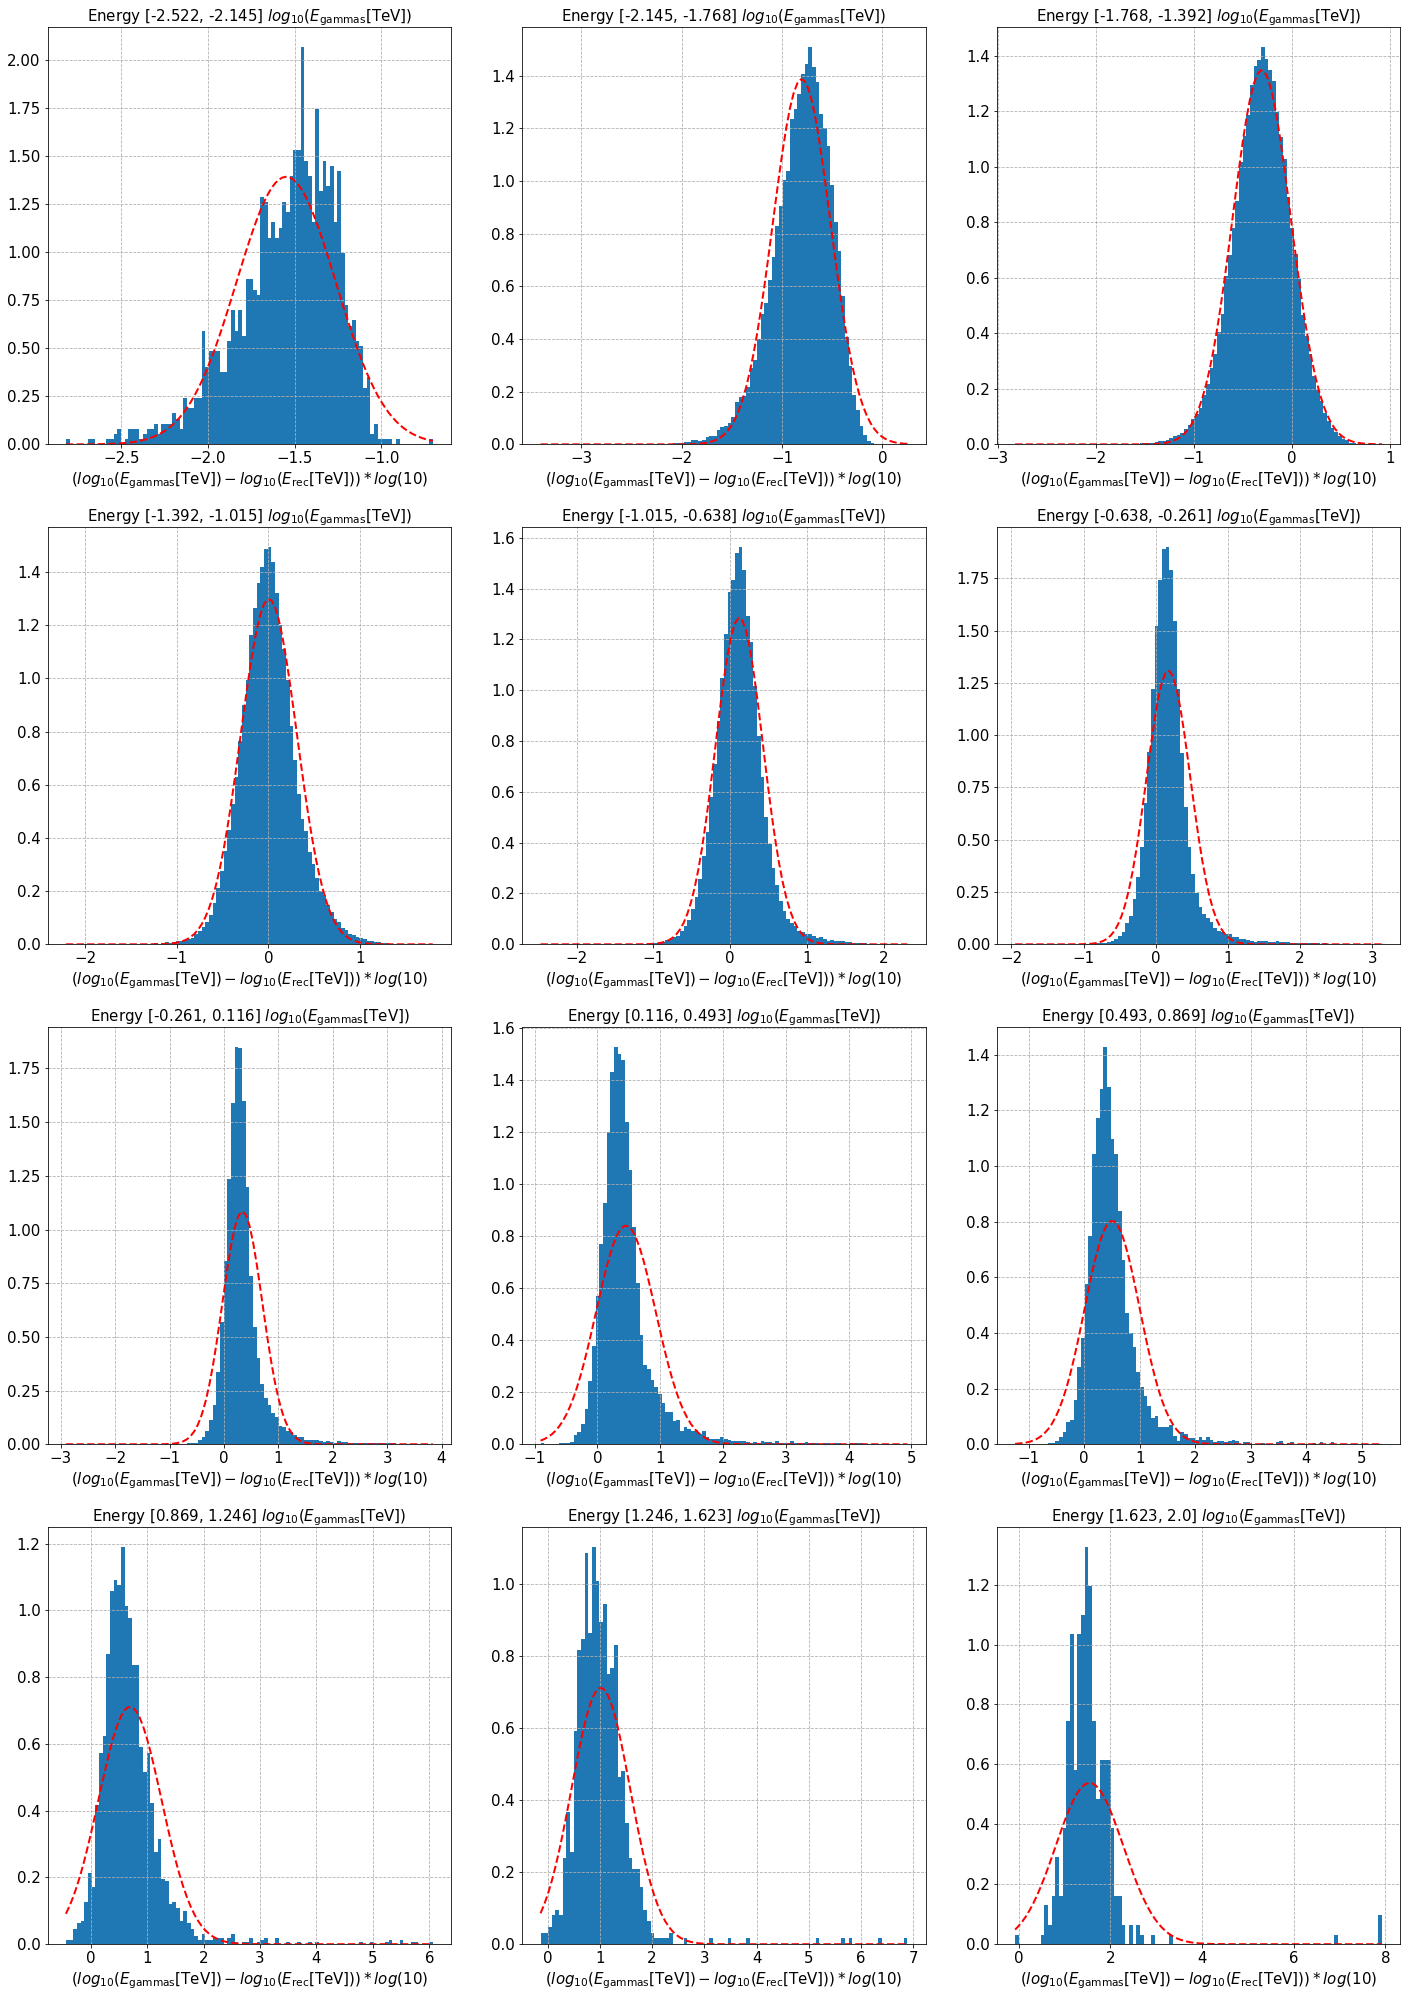

In [60]:
###############################################################################

###################### BEST MODEL ENERGY HISTOGRAMS ###########################                

###############################################################################
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

df = pd.read_pickle(baselineer)

n_rows = 4  # how many rows figures
n_cols = 3  # how many cols figures
n_figs = n_rows * n_cols

edges = np.linspace(min(df['GroundTruth']), 2, n_figs + 1)
mus = np.array([])
sigmas = np.array([])

fig = plt.figure(figsize=(20, 28))
matplotlib.rcParams.update({'font.size': 15})

for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        # print('\nEdge1: ', edge1, ' Idxs: ', n_cols * i + j)
        # print('Edge2: ', edge2, ' Idxs: ', n_cols * i + j + 1)
        dfbe = df[(df['GroundTruth'] >= edge1) & (df['GroundTruth'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        difE = ((dfbe['GroundTruth'] - dfbe['Predicted']) * np.log(10))
        #section = difE[abs(difE) < 1.5]
        mu, sigma = norm.fit(difE)
        print('MU: ', mu, 'SIGMA: ', sigma, 'N EVENTS:', dfbe.shape[0])
        mus = np.append(mus, mu)
        sigmas = np.append(sigmas, sigma)
        n, bins, patches = plt.hist(difE, 100, density=True, alpha=1)
        y = norm.pdf(bins, mu, sigma)
        plt.plot(bins, y, 'r--', linewidth=2)
        plt.xlabel('$(log_{10}(E_{\mathrm{gammas}}\mathrm{[TeV]})-log_{10}(E_{\mathrm{rec}}\mathrm{[TeV]}))*log(10)$', fontsize=15)
        # plt.figtext(0.15, 0.9, 'Mean: ' + str(round(mu, 4)), fontsize=10)
        # plt.figtext(0.15, 0.85, 'Std: ' + str(round(sigma, 4)), fontsize=10)
        plt.title('Energy [' + str(round(edge1, 3)) + ', ' + str(round(edge2, 3)) + '] $log_{10}(E_{\mathrm{gammas}}\mathrm{[TeV]})$',
                 fontsize=15)
        plt.grid(b=True, which='major', linestyle='--')
        plt.grid(b=True, which='minor', linestyle='--')

#fig.tight_layout(rect=[0, 0.03, 1, 0.85])
fig.tight_layout()
plt.show()
fig.savefig('energy_best_histogram.eps', format='eps', transparent=False)

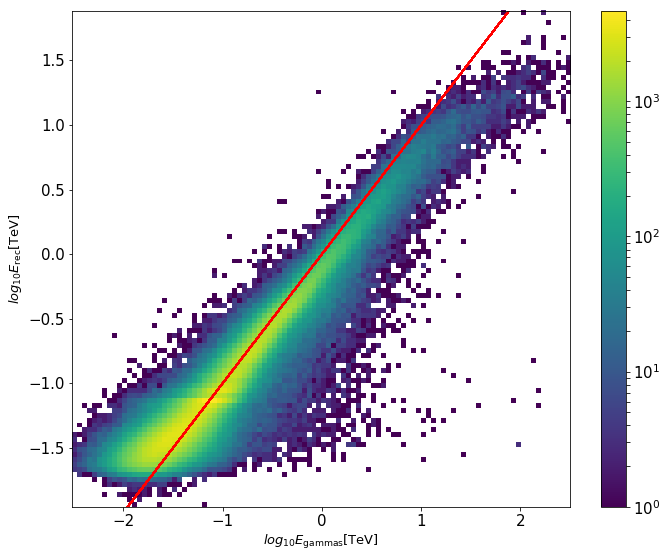

In [44]:
###############################################################################

###################### BEST MODEL ENERGY HISTOGRAM 2D #########################                

###############################################################################

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
from scipy.stats import norm

df = pd.read_pickle(baselineer)

fig = plt.figure(figsize=(10, 8))

hE = plt.hist2d(df['GroundTruth'], df['Predicted'], bins=100, norm=LogNorm())
plt.colorbar(hE[3])
plt.xlabel('$log_{10}E_{\mathrm{gammas}}$[TeV]', fontsize=13)
plt.ylabel('$log_{10}E_{\mathrm{rec}}$[TeV]', fontsize=13)
plt.plot(df['GroundTruth'], df['GroundTruth'], "-", color='red')

#plt.title('Histogram2D - Energy reconstruction')
fig.tight_layout()
plt.show()
fig.savefig('energy_best_hist2d.pdf', format='pdf', transparent=True)

In [1]:
def get_theta2_68(pkl, npoints, rf=False):
    
    df = pd.read_pickle(pkl)
    
    energy = 'energy'
    alt = 'src_x'
    az = 'src_y'
    alt_reco = 'src_x_rec'
    az_reco = 'src_y_rec'
    if rf:
        df = df[df['label'] == 1]
        energy = 'mc_energy'
        alt = 'd_alt'
        az = 'd_az'
        alt_reco = 'd_alt_reco'
        az_reco = 'd_az_reco'
        
    
    edges = np.linspace(min(df[energy]), 2, npoints + 1)
    theta2_68 = np.array([])

    for i in range(npoints):
        edge1 = edges[i]
        edge2 = edges[i+1]
        dfbe = df[(df[energy] >= edge1) & (df[energy] < edge2)]
        theta2 = (dfbe[alt] - dfbe[alt_reco]) ** 2 + (dfbe[az] - dfbe[az_reco]) ** 2
        # 68% containement computation
        total = len(theta2)
        hist = np.histogram(theta2, bins=1000)
        for k in range(0, len(hist[0]) + 1):
            fraction = np.sum(hist[0][:k]) / total
            if fraction > 0.68:
                #if rf:
                #    print('\nTotal: ', total)
                #    print('0.68 of total:', np.sum(hist[0][:k]))
                #    print('Fraction:', fraction)
                theta2_68 = np.append(theta2_68, hist[1][k])
                break
                
    # back to linear
    edges = np.power(10, edges)
    bin_centers = (edges[:-1] + edges[1:]) / 2
        
    return bin_centers, theta2_68

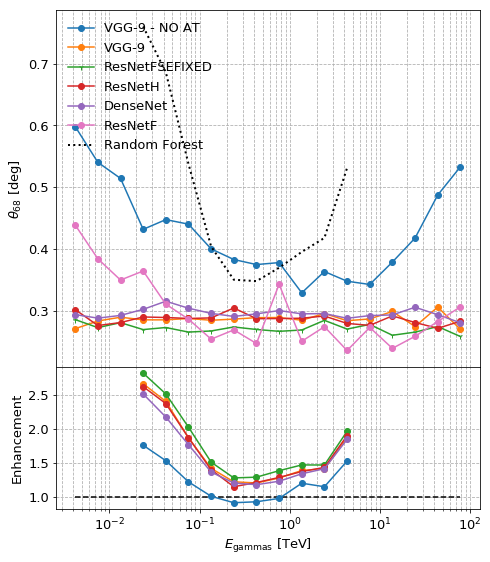

In [3]:
###############################################################################

######################################### DIRE RECO ###########################                

###############################################################################

# direction reconstruction
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy import interpolate
import numpy as np

baselineNOATdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-18_15-55/train-history'
baselineNOATdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-18_15-55/ang_reso_plt.npz'
baselineNOATdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-18_15-55/BaseLine_49_0.50128_0.45132.h5_test.pkl'

baselinedh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-16_16-29/train-history'
baselinedres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-16_16-29/ang_reso_plt.npz'
baselinedtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/BaseLine_xy_2019-05-16_16-29/BaseLine_25_0.34697_0.32997.h5_test.pkl'

resnetfsedh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_xy_2019-05-15_23-19/train-history'
resnetfsedres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_xy_2019-05-15_23-19/ang_reso_plt.npz'
resnetfsedtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/SUCCESSFUL/ResNetFSE_xy_2019-05-15_23-19/ResNetFSE_48_0.21978_0.22281.h5_test.pkl'

resnetfseFIXEDdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetFSEFixed_xy_2019-06-13_10-00/train-history'
resnetfseFIXEDdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetFSEFixed_xy_2019-06-13_10-00/ang_reso_plt.npz'
resnetfseFIXEDdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetFSEFixed_xy_2019-06-13_10-00/ResNetFSEFixed_50_0.21650_0.22598.h5_test.pkl'

resnetfdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetF_xy_2019-06-12_16-26/train-history'
resnetfdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetF_xy_2019-06-12_16-26/ang_reso_plt.npz'
resnetfdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetF_xy_2019-06-12_16-26/ResNetF_40_0.20012_0.23381.h5_test.pkl'

resnethdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_xy_2019-05-24_10-19/train-history'
resnethdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_xy_2019-05-24_10-19/ang_reso_plt.npz'
resnethdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetH_xy_2019-05-24_10-19/ResNetH_34_0.18375_0.21594.h5_test.pkl'

resnethsedh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_xy_2019-05-25_09-40/train-history'
resnethsedres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_xy_2019-05-25_09-40/ang_reso_plt.npz'
resnethsedtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/ResNetHSE_xy_2019-05-25_09-40/ResNetHSE_49_0.21935_0.22435.h5_test.pkl'

baselineNOATMSEdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-09_01-05/train-history'
baselineNOATMSEdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-09_01-05/ang_reso_plt.npz'
baselineNOATMSEdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-09_01-05/BaseLine_35_0.80899_0.87613.h5_test.pkl'

baselineMSEdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-10_14-07/train-history'
baselineMSEdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-10_14-07/ang_reso_plt.npz'
baselineMSEdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/BaseLine_xy_2019-06-10_14-07/BaseLine_18_0.30677_0.33684.h5_test.pkl'

resnetfseMSEdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/ResNetFSE_xy_2019-06-09_10-43/train-history'
resnetfseMSEdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/ResNetFSE_xy_2019-06-09_10-43/ang_reso_plt.npz'
resnetfseMSEdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/MSE/ResNetFSE_xy_2019-06-09_10-43/ResNetFSE_47_0.12410_0.17007.h5_test.pkl'

densenetdh = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet_xy_2019-04-21_09-20/train-history'
densenetdres = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet_xy_2019-04-21_09-20/ang_reso_plt.npz'
densenetdtest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/regression/thesis/DenseNet_xy_2019-04-21_09-20/DenseNet_49_0.24333_0.24288.h5_test.pkl'

#history
baselineNOAT_history = pickle.load(open(baselineNOATdh, 'rb'))
baseline_history = pickle.load(open(baselinedh, 'rb'))
resnetfse_history = pickle.load(open(resnetfsedh, 'rb'))
resnetfseFIXED_history = pickle.load(open(resnetfsedh, 'rb'))
resneth_history = pickle.load(open(resnethdh, 'rb'))
resnethse_history = pickle.load(open(resnethsedh, 'rb'))
densenet_history = pickle.load(open(densenetdh, 'rb'))
resnetf_history = pickle.load(open(resnetfdh, 'rb'))

baselineNOATMSE_history = pickle.load(open(baselineNOATMSEdh, 'rb'))
baselineMSE_history = pickle.load(open(baselineMSEdh, 'rb'))
resnetfseMSE_history = pickle.load(open(resnetfseMSEdh, 'rb'))

# angulare reso
npoints = 18
baselineNOAT_bc, baselineNOAT_areso = get_theta2_68(baselineNOATdtest, npoints)
baseline_bc, baseline_areso = get_theta2_68(baselinedtest, npoints)
resnetfse_bc, resnetfse_areso = get_theta2_68(resnetfsedtest, npoints)
resnetfseFIXED_bc, resnetfseFIXED_areso = get_theta2_68(resnetfsedtest, npoints)
resneth_bc, resneth_areso = get_theta2_68(resnethdtest, npoints)
resnethse_bc, resnethse_areso = get_theta2_68(resnethsedtest, npoints)
densenet_bc, densenet_areso = get_theta2_68(densenetdtest, npoints)
resnetf_bc, resnetf_areso = get_theta2_68(resnetfdtest, npoints)

baselineNOATMSE_bc, baselineNOATMSE_areso = get_theta2_68(baselineNOATMSEdtest, npoints)
baselineMSE_bc, baselineMSE_areso = get_theta2_68(baselineMSEdtest, npoints)
resnetfseMSE_bc, resnetfseMSE_areso = get_theta2_68(resnetfseMSEdtest, npoints)

rftest = '/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/RF_test-table.pkl'
rf_bc, rf_areso = get_theta2_68(rftest, npoints, rf=True)

############# LOAD POINTS RF #############################

nocutcsv = pd.read_csv('/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/nocut.csv')
softcutcsv = pd.read_csv('/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/softcut.csv')
hardcutcsv = pd.read_csv('/Volumes/home/Documenti/Studio/Unipd/Ingegneria delle Telecomunicazioni/2 Anno/thesis/results/RF_results/hardcut.csv')
    
# need to interpolate rf points, in order to compare them with the other models

f_rf_a = interpolate.interp1d(nocutcsv['x'], nocutcsv['no_cut'], kind='linear')

#take only points inside hand copied curve
which_idxs = np.where((baselineNOAT_bc >=nocutcsv['x'].min()) & (baselineNOAT_bc <=nocutcsv['x'].max()))  
x_nocut_new = baselineNOAT_bc[which_idxs]
y_nocut_new = f_rf_a(x_nocut_new)
    
    
epochs = 50

# training & test loss
fig = plt.figure(figsize=(7, 6))

matplotlib.rcParams.update({'font.size': 13})
cmap = plt.get_cmap("tab10")

#plt.plot(baselineNOAT_history['val_losses'], label='VGG-9 - NO AT', color=cmap(0))
plt.plot(baseline_history['val_losses'], label='VGG-9', color=cmap(1))
plt.plot(resnetfse_history['val_losses'], label='ResNetFSE', color=cmap(2))
plt.plot(resneth_history['val_losses'], label='ResNetH', color=cmap(3))
plt.plot(densenet_history['val_losses'], label='DenseNet', color=cmap(4))
#plt.plot(resnethse_history['val_losses'], label='ResNetHSE', color=cmap(5))
plt.plot(resnetf_history['val_losses'], label='ResNetF', color=cmap(6))

#plt.plot(baselineNOAT_history['losses'], ':', color=cmap(0))
plt.plot(baseline_history['losses'], ':', color=cmap(1))
plt.plot(resnetfse_history['losses'], ':', color=cmap(2))
plt.plot(resneth_history['losses'], ':', color=cmap(3))
plt.plot(densenet_history['losses'], ':', color=cmap(4))
#ax.plot(resnethse_history['losses'], ':', color=cmap(5))
plt.plot(resnetf_history['losses'], ':', color=cmap(6))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left', fancybox=True, framealpha=0.)
plt.grid(b=True, which='major', linestyle='--')
plt.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('dirreco_losshistory.eps', format='eps', transparent=False)
#############################################################################

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 8), sharex=True, gridspec_kw={'hspace': 0,'height_ratios': [2.5, 1]})

ax = axs[0]
#ax.set_yscale('log')
ax.semilogx(baselineNOAT_bc, np.sqrt(baselineNOAT_areso), label='VGG-9 - NO AT', color=cmap(0), marker='o')
ax.semilogx(baseline_bc, np.sqrt(baseline_areso), label='VGG-9', color=cmap(1), marker='o')
#ax.semilogx(resnetfse_bc, np.sqrt(resnetfse_areso), label='ResNetFSE', color=cmap(2), marker='o')
ax.semilogx(resnetfseFIXED_bc, np.sqrt(resnetfseFIXED_areso), label='ResNetFSEFIXED', color=cmap(2), marker='1')
ax.semilogx(resneth_bc, np.sqrt(resneth_areso), label='ResNetH', color=cmap(3), marker='o')
ax.semilogx(densenet_bc, np.sqrt(densenet_areso), label='DenseNet', color=cmap(4), marker='o')
#ax.semilogx(resnethse_bc, np.sqrt(resnethse_areso), label='ResNetHSE', color=cmap(5), marker='o')
ax.semilogx(resnetf_bc, np.sqrt(resnetf_areso), label='ResNetF', color=cmap(6), marker='o')

#ax.semilogx(baselineNOATMSE_bc, np.sqrt(baselineNOATMSE_areso), label='VGG-9 - NO AT - MSE', color=cmap(0), marker='1')
#ax.semilogx(baselineMSE_bc, np.sqrt(baselineMSE_areso), label='VGG-9 - MSE', color=cmap(1), marker='1')
#ax.semilogx(resnetfseMSE_bc, np.sqrt(resnetfseMSE_areso), label='ResNetFSE - MSE', color=cmap(2), marker='1')

#ax.semilogx(rf_bc, np.sqrt(rf_areso), label='Random Forest', color='black', marker='o') # linestyle='o'
ax.semilogx(x_nocut_new, y_nocut_new, label='Random Forest', linestyle=':', color='black', linewidth=2)
#ax.semilogx(softcutcsv['x'], softcutcsv['soft_cut'], label='Random Forest - soft cut', color='black', marker='v')
#ax.semilogx(hardcutcsv['x'], hardcutcsv['hard_cut'], label='Random Forest - hard cut', color='black', marker='h')

ax.set_xlabel('$E_{\mathrm{gammas}}$ [TeV]')
ax.set_ylabel(r'$\theta_{68}$ [deg]')
ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

ax = axs[1]
ax.semilogx(x_nocut_new, y_nocut_new/np.sqrt(baselineNOAT_areso[which_idxs]), label='RF/VGG-9 - NO AT', color=cmap(0), marker='o')
ax.semilogx(x_nocut_new, y_nocut_new/np.sqrt(baseline_areso[which_idxs]), label='RF/VGG-9', color=cmap(1), marker='o')
ax.semilogx(x_nocut_new, y_nocut_new/np.sqrt(resnetfse_areso[which_idxs]), label='RF/ResNetFSE', color=cmap(2), marker='o')
ax.semilogx(x_nocut_new, y_nocut_new/np.sqrt(resneth_areso[which_idxs]), label='RF/ResNetH', color=cmap(3), marker='o')
ax.semilogx(x_nocut_new, y_nocut_new/np.sqrt(densenet_areso[which_idxs]), label='RF/DenseNet', color=cmap(4), marker='o')
#ax.semilogx(x_nocut_new, y_nocut_new/np.sqrt(resnethse_areso[which_idxs]), label='RF/ResNetHSE', color=cmap(5), marker='o')

ax.hlines(1,baselineNOAT_bc.min(),baselineNOAT_bc.max(), color='black', linestyles='dashed')

ax.set_xlabel('$E_{\mathrm{gammas}}$ [TeV]')
ax.set_ylabel('Enhancement')
#ax.legend(loc='upper left', fancybox=True, framealpha=0.)
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle='--')

plt.tight_layout()
fig.savefig('dirreco_results.eps', format='eps', transparent=False)

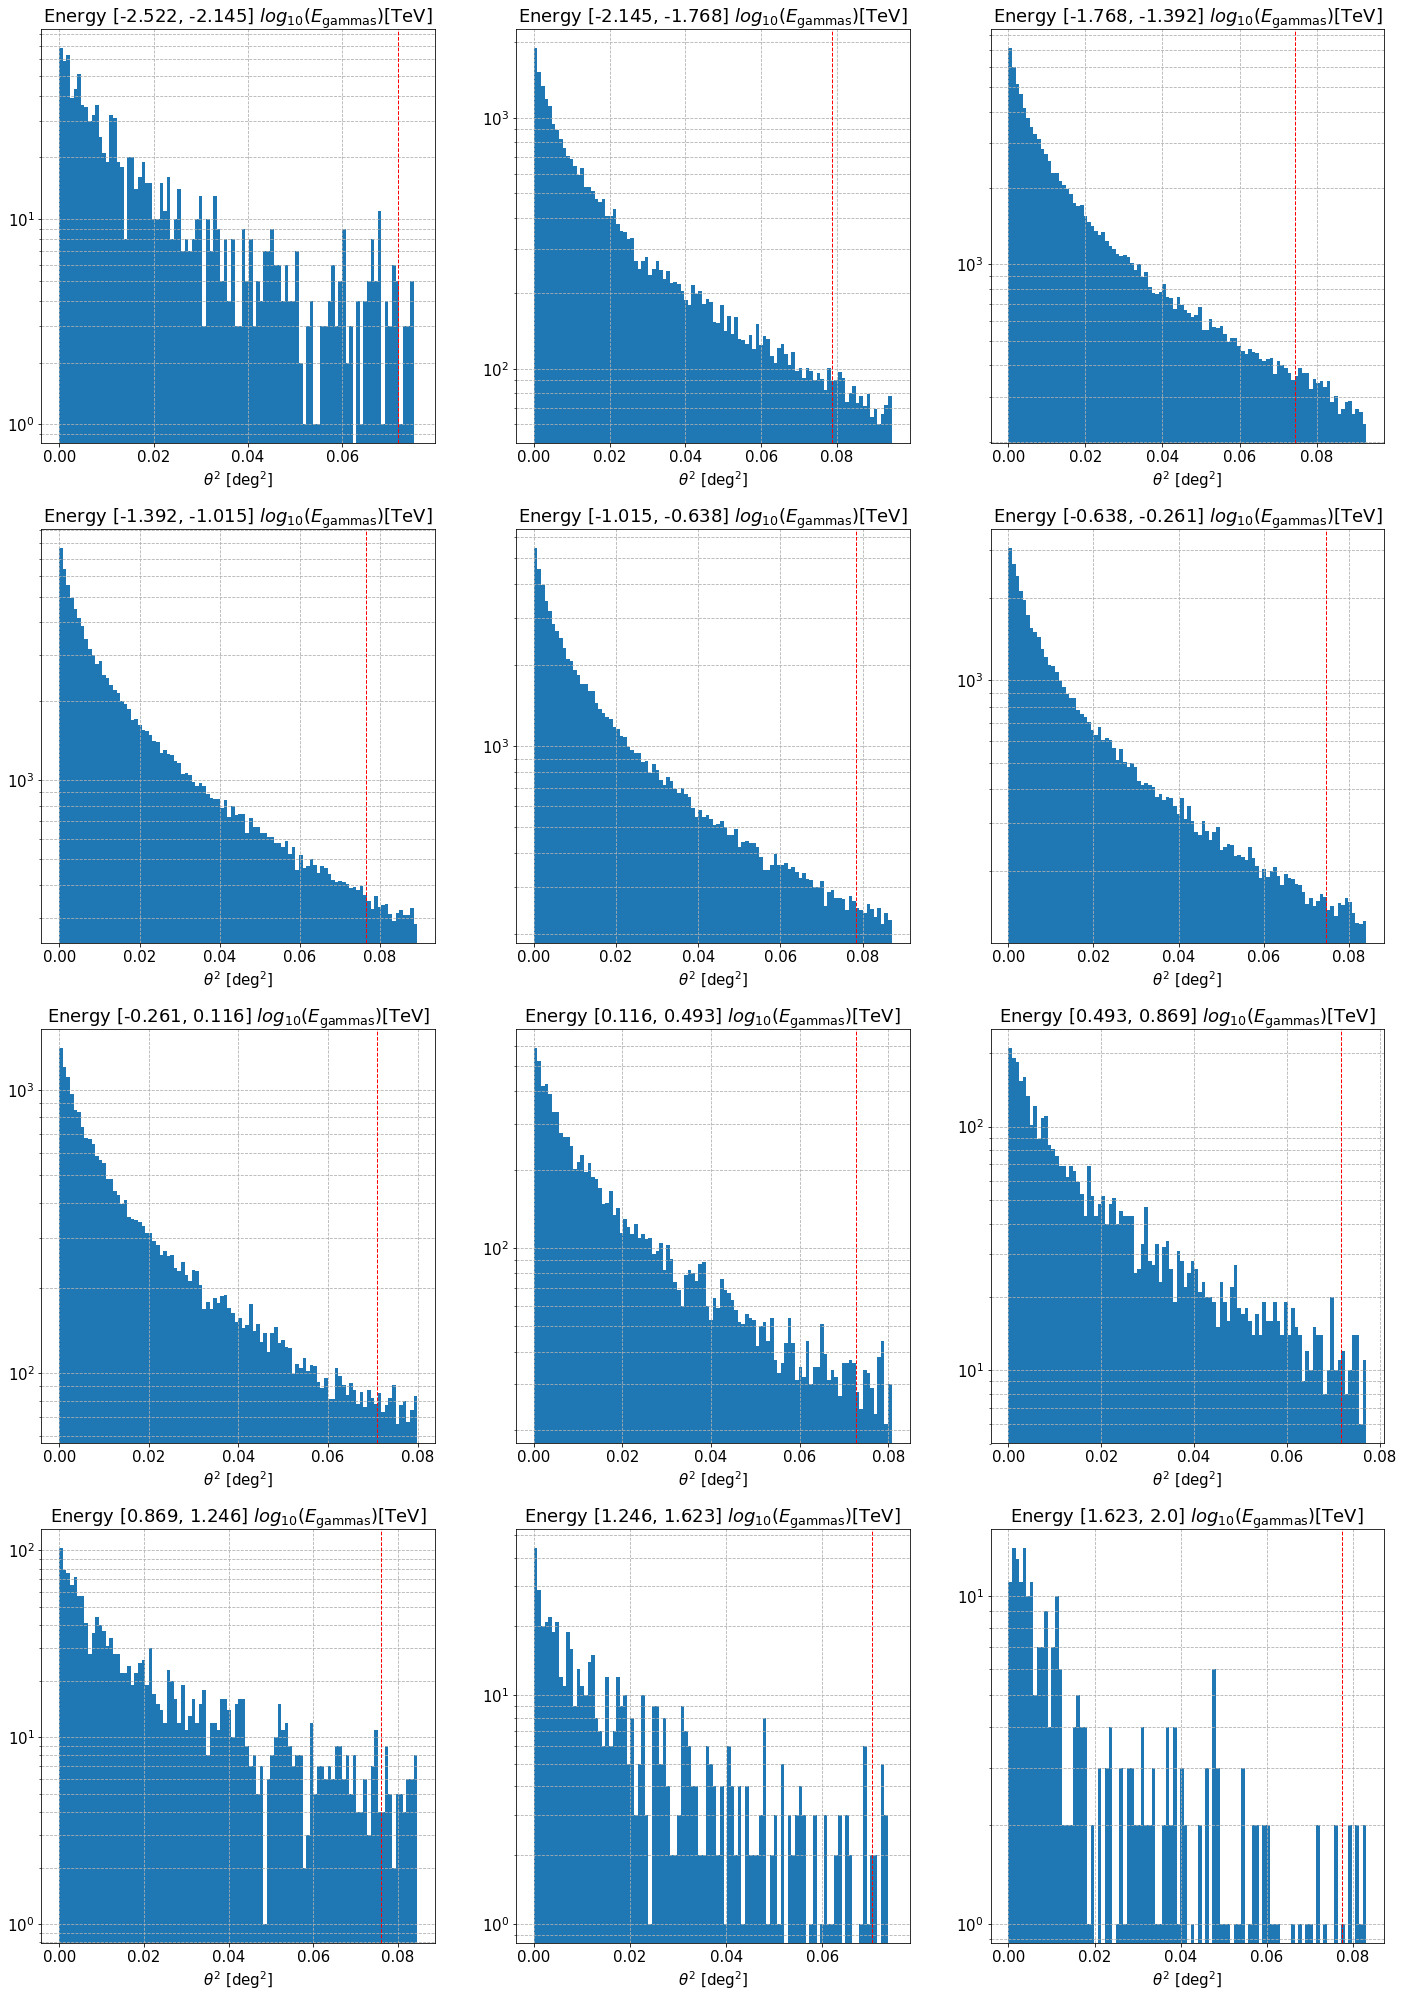

In [23]:
###############################################################################

###################### BEST MODEL DIRECTION HISTOGRAMS ########################                

###############################################################################

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

df = pd.read_pickle(resnetfsedtest)

n_rows = 4  # how many rows figures
n_cols = 3  # how many cols figures
n_figs = n_rows * n_cols

edges = np.linspace(min(df['energy']), 2, n_figs + 1)
theta2_68 = np.array([])

fig = plt.figure(figsize=(20, 28))
matplotlib.rcParams.update({'font.size': 15})

for i in range(n_rows):
    for j in range(n_cols):
        # df with ground truth between edges
        edge1 = edges[n_cols * i + j]
        edge2 = edges[n_cols * i + j + 1]
        dfbe = df[(df['energy'] >= edge1) & (df['energy'] < edge2)]
        # histogram
        subplot = plt.subplot(n_rows, n_cols, n_cols * i + j + 1)
        theta2 = (dfbe['src_x'] - dfbe['src_x_rec']) ** 2 + (dfbe['src_y'] - dfbe['src_y_rec']) ** 2
        total = len(theta2)
        # theta2_68 = np.append(theta2_68, np.percentile(theta2, 68))
        hist = np.histogram(theta2, bins=1000)
        for k in range(0, len(hist[0]) + 1):
            fraction = np.sum(hist[0][:k]) / total
            if fraction > 0.68:
                #print('\nTotal: ', total)
                #print('0.68 of total:', np.sum(hist[0][:k]))
                #print('Fraction:', fraction)
                theta2_68 = np.append(theta2_68, hist[1][k])
                break
        n, bins, patches = plt.hist(theta2, bins=100, range=(0, hist[1][k+1])) #hist[1][k+1] one bin more than 68% cont
        plt.axvline(hist[1][k], color='r', linestyle='dashed', linewidth=1)
        plt.yscale('log', nonposy='clip')
        plt.xlabel(r'$\theta^{2}$ [deg$^2$]', fontsize=15)
        plt.title(
            'Energy [' + str(round(edge1, 3)) + ', ' + str(round(edge2, 3)) + '] $log_{10}(E_{\mathrm{gammas}})$[TeV]')
        plt.grid(b=True, which='major', linestyle='--')
        plt.grid(b=True, which='minor', linestyle='--')
        # + ' Mean: ' + str(round(mu, 3)) + ' Std: ' + str(round(sigma, 3)))

fig.tight_layout()
plt.show()
fig.savefig('best_direco_histograms.eps', format='eps', transparent=False)